This is the source jupyer notebook for paper 

Dingyi Zhuang, Siyu Hao, Lee Der-Horng, *From compound word to metropolitan station: Semantic similarity analysis using smart card data*. It is under review in the journal *Transportation Research Part C: Emerging Technology*

Details can be found in my homepage https://zhuangdingyi.github.io/

This notebook trains the semantic models for mobility and location, based on the data generated in *Pre-process data and crawl external information.ipynb*. To be noticed that this notebook is the integration of previous experiements, which means that some laborious and time-consuming process will not re-run in this notbook

# Load modules, variables and self-defined functions

In [94]:
import numpy as np
import pandas as pd
import csv
import time,datetime
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
from sklearn.externals import joblib
from scipy import spatial
from scipy.interpolate import interp1d

from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
import sklearn
#import scipy
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
#import keras
#import keras.backend as K
#from tensorflow.keras.keras_tqdm import TQDMNotebookCallback
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = 20,10

In [14]:
print(tf.__version__) # Keras is intergrated when I rewrite the notbook

1.9.0


In [ ]:
# Timestamps range
# 5-7 pre-morning peak,7-10 morning peak, 10-16 morning off-peak, 
# 16-17 pre-evening peak, 17-19 evening peak,19-22 late evening peak, 22 evening off-peak,
# The above 7 time intervals will be transformed in to a 0-6 catagorical number, then turned into one-hots
tint_dict={0:'pre-morning peak',1:'morning peak',2:'morning off-peak',3:'pre-evening peak',4:'evening peak',5:'late evening peak',6:'evening off-peak'}
day_dict={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

In [16]:
#Class that reserves loss error and accuracy
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
        
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
            # deviation
            #plt.plot(iters, self.dev_metric[loss_type], 'y', label='deviation')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

Singapre has MRT lines: ['NS','EW','NE','CC','CE','DT','TE','JS','JE','BP','CG','JW','PW','PE','SW','SE','STC','PTC']

Import MRT station index, POI and MRT line information

In [21]:
MRTStops=pd.read_csv('../MRTStops_Geo_POI_Interchange_Lines_Handmade_NewPOI_20180813_2.csv')
MRTStops_lines=pd.read_csv('../MRTStops_Geo_POI_Interchange_LinesNumbered.csv')
MRTLineNames=['NS','EW','NE','CC','CE','BP','CG','PE','SW','SE']

stationDict=MRTStops['MRTStopsName']
stationDict=stationDict.to_dict()
stationDict_re=dict(zip(stationDict.values(),stationDict.keys()))

Load POI information

In [64]:
# Load POI and spatial data
stationFeat_tint_dict=joblib.load('../stationFeat_tint_dict.asv')
poi_tf_idf=joblib.load('../poi_tf_idf.asv')
poi_tf_idf_svd_labels=joblib.load('../poi_tf_idf_svd_af_labels_20180813_satified.asv')
station_POI_Intsec=pd.read_csv('../MRTStops_Geo_POI_Interchange_Lines_Handmade_NewPOI_20180813.csv')
columns_selected=['total_flow','adu_dis','chd_dis','sen_dis','ori_dist','des_dist','ori_runtime','des_runtime']
#'establishment','food','store','restaurant', 'health','finance','school'
poi_selected=['atm','bank','bus_station', 'transit_station', 'place_of_worship',
       'supermarket', 'shopping_mall', 'education' , 'parking', 'park',
       'political', 'storage', 'intsec','lodging','hospital','car_rental',
        'car_dealer','car_repair','bar','cafe','local_government_office','bicycle_store']
poi_selected=np.array(poi_selected)    
poi_mat=np.mat(station_POI_Intsec.loc[:,poi_selected])
spa_mat=np.zeros((0,len(columns_selected)))
for i in range(7):
    spa_mat=np.row_stack((spa_mat,stationFeat_tint_dict[i]))
spa_mat_meta=joblib.load('../spa_mat_meta.asv')

Load TI-IDF-SVD clusteres and flow information

In [90]:
# Load parameters
line_stn_dict=joblib.load('../line_stn_dict.asv')
#map_sg=gp.read_file('maps/sla-cadastral-land-parcel/sla-cadastral-land-parcel-geojson.geojson')
row_names=joblib.load('../cluster_row_names.asv') # cluster row names
poi_tf_idf_svd_clusters=[int(e[-1]) for e in row_names]

stns_sP_sF=joblib.load('../stn_sP_sF.asv')
stns_sP_dF=joblib.load('../stns_sP_dF.asv')
stns_dP_sF=joblib.load('../stns_dP_sF.asv')
stns_dP_dF=joblib.load('../stns_dP_dF.asv')
prop_stns_sP_sF=joblib.load('../prop_stns_sP_sF.asv')
prop_stns_dP_sF=joblib.load('../prop_stns_dP_sF.asv')

Self-defined functions to extract features from stations.

In [22]:
def getFeatMatRowIdx(MRTStopsName,interval):
    staNum=stationDict_re[MRTStopsName]
    return staNum+interval*len(stationDict_re)

def getWeirdStations(num_flowmat):
    if num_flowmat<2:
        return "Long or Lat"
    else:
        num_flowmat=num_flowmat-2 # long and lat
        if num_flowmat<122:
            return stationDict[num_flowmat]
        elif 122<=num_flowmat<244:
            return stationDict[num_flowmat-122]
        else:
            return "Not in stopsDict, should be time and day"

def getStationLineNames(stn_num):
    line_dict={}
    lines=[]
    dummy=[]
    for line in MRTLineNames:
        eq1='line_dict["'+line+'"]="'+line+'"'
        eq2=line+'=MRTStops[MRTStops.'+line+'==1].index'
        exec(eq1)
        exec(eq2)
        eq3= 'lines.append( line_dict["'+line+'"]  ) if stn_num in '+line+' else dummy.append(1)'
        exec(eq3)
    return lines
          
def getStationNames(stn_num):
    res=[]
    lines=[]
    for i in range(len(stn_num)):
        tmp=stn_num[i]%122
        res.append(stationDict[tmp])
        lines.append(getStationLineNames(tmp))
    return list(set(res)),res,lines

# Construct auto-encoder for dimension reduction among 7 time intervals(7 models)

In [95]:
# This notebook is in the subfolder. It read from previous folder but generate files in its current folder
flowDict=joblib.load('../flowMat_dict_onehot.asv')


mat_sta_id=np.eye(122)
for i in range(6):
    tmp=np.eye(122)
    mat_sta_id=np.row_stack((mat_sta_id,tmp))
del tmp


for tint in range(7):
    eq0='flowMat_tint_'+str(tint)+'=np.empty(shape=[0,373])' # The feature is 244+7 adding 122 dimension one-hot for station identification
    exec(eq0)

del tint,eq0

cnt=0
for day in ['0319','0320','0321','0322','0323','0324','0325']:
    eq1='flowMat_'+day+'=flowDict['+str(cnt)+']'
    eq2='tmp=np.column_stack((mat_sta_id,flowMat_'+day+ '[:,:-7]))'
    exec(eq1)
    exec(eq2)
    
    # flowMat has 122*7 rows, from Monday to Sunday
    flowMat_tint_0=np.append(flowMat_tint_0,tmp[0:122,:],axis=0)
    flowMat_tint_1=np.append(flowMat_tint_1,tmp[122:(122*2),:],axis=0)
    flowMat_tint_2=np.append(flowMat_tint_2,tmp[(122*2):(122*3),:],axis=0)
    flowMat_tint_3=np.append(flowMat_tint_3,tmp[(122*3):(122*4),:],axis=0)
    flowMat_tint_4=np.append(flowMat_tint_4,tmp[(122*4):(122*5),:],axis=0)
    flowMat_tint_5=np.append(flowMat_tint_5,tmp[(122*5):(122*6),:],axis=0)
    flowMat_tint_6=np.append(flowMat_tint_6,tmp[(122*6):(122*7),:],axis=0)
    
    cnt+=1
del cnt
flowDict_int={}
for i in range(7):
    eq3='flowDict_int['+str(i)+']=flowMat_tint_'+str(i)
    exec(eq3)
joblib.dump(flowDict_int,'flowMat_dict_tint_stn_onehot.asv')

# Begin to train 7 separate models 
# Take the first as example
flowDict_int=joblib.load('../flowMat_dict_tint_stn_onehot.asv')
flowDict_tint=joblib.load('../flowMat_dict_tint.asv')
train_data_tint_0=flowDict_int[0]
train_data_tint_1=flowDict_int[1]
train_data_tint_2=flowDict_int[2]

n_dim=np.shape(train_data_tint_0)[1]
n_samples=np.shape(train_data_tint_0)[0]
# Normalization

# Mean-std normalization ( with poor performance)
#norm_mean_0=np.mean(train_data_tint_0,axis=0)
#norm_std_0=np.std(train_data_tint_0,axis=0)
#train_data_tint_0=(train_data_tint_0-norm_mean_0)/norm_std_0
#train_data_tint_0=np.nan_to_num(train_data_tint_0)

# Max normalization
train_data_tint_0=flowDict_tint[0]
train_data_tint_0,norm_tint_ori_0=sklearn.preprocessing.normalize(train_data_tint_0,norm='max',return_norm=True,axis=0)

train_data_tint_1=flowDict_tint[1]
train_data_tint_1,norm_tint_ori_1=sklearn.preprocessing.normalize(train_data_tint_1,norm='max',return_norm=True,axis=0)

train_data_tint_2=flowDict_tint[2]
train_data_tint_2,norm_tint_ori_2=sklearn.preprocessing.normalize(train_data_tint_2,norm='max',return_norm=True,axis=0)

train_data_tint_3=flowDict_tint[3]
train_data_tint_3,norm_tint_ori_3=sklearn.preprocessing.normalize(train_data_tint_3,norm='max',return_norm=True,axis=0)

train_data_tint_4=flowDict_tint[4]
train_data_tint_4,norm_tint_ori_4=sklearn.preprocessing.normalize(train_data_tint_4,norm='max',return_norm=True,axis=0)

train_data_tint_5=flowDict_tint[5]
train_data_tint_5,norm_tint_ori_5=sklearn.preprocessing.normalize(train_data_tint_5,norm='max',return_norm=True,axis=0)

train_data_tint_6=flowDict_tint[6]
train_data_tint_6,norm_tint_ori_6=sklearn.preprocessing.normalize(train_data_tint_6,norm='max',return_norm=True,axis=0)

flowMat_dict=joblib.load('../flowMat_dict_onehot.asv')
#train_data_test=tf.data.Dataset.from_tensor_slices(flowMat_dict[0])
#train_data_test=np.column_stack((mat_sta_id,flowMat_dict[0][:,:-7]))
train_data_test=(flowMat_dict[0])
train_data_test=np.column_stack((mat_sta_id,train_data_test))
norm_test=np.linalg.norm(train_data_test,ord=1,axis=0,keepdims=True)
train_data_test=train_data_test/norm_test
train_data_test[np.isnan(train_data_test)]=0
n_dim_test=np.shape(train_data_test)[1]
n_samples_test=np.shape(train_data_test)[0]

## Build auto-encoder model

In [30]:
# Build the autoencoder model
#---- Hyper parameters
#K.set_value(sgd.lr,1e-6)

encoding_dim = 10
encode_layer1=256
encode_layer2=128
encode_layer3=64
encode_layer4=30

decode_layer1=encode_layer4
decode_layer2=encode_layer3
decode_layer3=encode_layer2
decode_layer4=encode_layer1

# this is our input placeholder
input_data = Input(shape=(n_dim,))
encode_decode_data=Input(shape=(encoding_dim,))

# encoder layers
encoded = Dense(encode_layer1, activation='relu')(input_data)
encoded = Dense(encode_layer2, activation='relu')(encoded)
encoded = Dense(encode_layer3, activation='relu')(encoded)
encoded = Dense(encode_layer4, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(decode_layer1, activation='relu')(encoder_output)
decoded = Dense(decode_layer2, activation='relu')(decoded)
decoded = Dense(decode_layer3, activation='relu')(decoded)
decoded = Dense(decode_layer4, activation='relu')(decoded)
decoded = Dense(n_dim, activation='tanh')(decoded)

# Decoder for saved models
decoder = Dense(decode_layer1, activation='relu')(encode_decode_data)
decoder = Dense(decode_layer2, activation='relu')(decoder)
decoder = Dense(decode_layer3, activation='relu')(decoder)
decoder = Dense(decode_layer4, activation='relu')(decoder)
decoder = Dense(n_dim, activation='tanh')(decoder)

In [32]:
help(Model)

Help on class Model in module tensorflow.python.keras.engine.training:

class Model(tensorflow.python.keras.engine.network.Network)
 |  `Model` groups layers into an object with training and inference features.
 |  
 |  There are two ways to instantiate a `Model`:
 |  
 |  1 - With the "functional API", where you start from `Input`,
 |  you chain layer calls to specify the model's forward pass,
 |  and finally you create your model from inputs and outputs:
 |  
 |  ```python
 |  import tensorflow as tf
 |  
 |  inputs = tf.keras.Input(shape=(3,))
 |  x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
 |  outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
 |  model = tf.keras.Model(inputs=inputs, outputs=outputs)
 |  ```
 |  
 |  2 - By subclassing the `Model` class: in that case, you should define your
 |  layers in `__init__` and you should implement the model's forward pass
 |  in `call`.
 |  
 |  ```python
 |  import tensorflow as tf
 |  
 |  class MyModel(tf.k

In [48]:
month=datetime.datetime.now().month
day=datetime.datetime.now().day
str(month)+str(day)

'101'

In [54]:
train_data_tint_0.shape

(854, 251)

In [ ]:
autoencoder_tint = Model(inputs=input_data, outputs=decoded)
# construct the encoder model for clustering and plotting
encoder_tint = Model(inputs=input_data, outputs=encoder_output)

ada=tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-06)
history_tint = LossHistory()

autoencoder_tint.compile(loss='mse',optimizer=ada)

# training
autoencoder_tint.fit(train_data_tint_0,train_data_tint_0,
                epochs=10**3,
                batch_size=256,
                shuffle=True,
                verbose=1,
                callbacks=[history_tint])

year=datetime.datetime.now().year
month=datetime.datetime.now().month
day=datetime.datetime.now().day

history_tint.loss_plot('epoch')
history_tint.loss_plot('batch')
autoencoder_tint.save('model_0801/autoencoder_tint_4layers_200000_{:}.h5'.format(str(year)+str(month)+str(day)))
encoder_tint.save('model_0801/encoder_tint_4layers_200000_{:}.h5'.format(str(year)+str(month)+str(day)))

## Directly load data from server

In [108]:
# Loading all the models
autoencoder_tint_0=tf.keras.models.load_model('../model_0801/autoencoder_withoutstn_tint_0_3layers_200000.h5')
encoder_tint_0=tf.keras.models.load_model('../model_0801/encoder_withoutstn_tint_0_3layers_200000.h5')
scaler_tint_0=joblib.load('../model_0801/scaler_without_tint_0.asv')

autoencoder_tint_1=tf.keras.models.load_model('../model_0801/autoencoder_withoutstn_tint_1_3layers_200000.h5')
encoder_tint_1=tf.keras.models.load_model('../model_0801/encoder_withoutstn_tint_1_3layers_200000.h5')
scaler_tint_1=joblib.load('../model_0801/scaler_without_tint_1.asv')


autoencoder_tint_2=tf.keras.models.load_model('../model_0801/autoencoder_withoutstn_tint_2_3layers_200000.h5')
encoder_tint_2=tf.keras.models.load_model('../model_0801/encoder_withoutstn_tint_2_3layers_200000.h5')
scaler_tint_2=joblib.load('../model_0801/scaler_without_tint_2.asv')

autoencoder_tint_3=tf.keras.models.load_model('../model_0801/autoencoder_withoutstn_tint_3_3layers_200000.h5')
encoder_tint_3=tf.keras.models.load_model('../model_0801/encoder_withoutstn_tint_3_3layers_200000.h5')
scaler_tint_3=joblib.load('../model_0801/scaler_without_tint_3.asv')

autoencoder_tint_4=tf.keras.models.load_model('../model_0801/autoencoder_withoutstn_tint_4_3layers_200000.h5')
encoder_tint_4=tf.keras.models.load_model('../model_0801/encoder_withoutstn_tint_4_3layers_200000.h5')
scaler_tint_4=joblib.load('../model_0801/scaler_without_tint_4.asv')

autoencoder_tint_5=tf.keras.models.load_model('../model_0801/autoencoder_withoutstn_tint_5_3layers_200000.h5')
encoder_tint_5=tf.keras.models.load_model('../model_0801/encoder_withoutstn_tint_5_3layers_200000.h5')
scaler_tint_5=joblib.load('../model_0801/scaler_without_tint_5_2.asv')

autoencoder_tint_6=tf.keras.models.load_model('../model_0801/autoencoder_withoutstn_tint_6_3layers_200000.h5')
encoder_tint_6=tf.keras.models.load_model('../model_0801/encoder_withoutstn_tint_6_3layers_200000.h5')
scaler_tint_6=joblib.load('../model_0801/scaler_without_tint_6.asv')

flowDict_int=joblib.load('../flowMat_dict_tint_stn_onehot.asv')
flowDict_tint=joblib.load('../flowMat_dict_tint.asv')

for i in range(7):
    eq0='train_data_tint_'+str(i)+'=flowDict_tint['+str(i)+']'
    eq1='train_data_tint_'+str(i)+'=scaler_tint_'+str(i)+'.transform(train_data_tint_'+str(i)+')'
    exec(eq0)
    exec(eq1)

encoded_tint_6=encoder_tint_6.predict(train_data_tint_6)
encoded_tint_5=encoder_tint_5.predict(train_data_tint_5)
encoded_tint_4=encoder_tint_4.predict(train_data_tint_4)
encoded_tint_3=encoder_tint_3.predict(train_data_tint_3)
encoded_tint_2=encoder_tint_2.predict(train_data_tint_2)
encoded_tint_1=encoder_tint_1.predict(train_data_tint_1)
encoded_tint_0=encoder_tint_0.predict(train_data_tint_0)

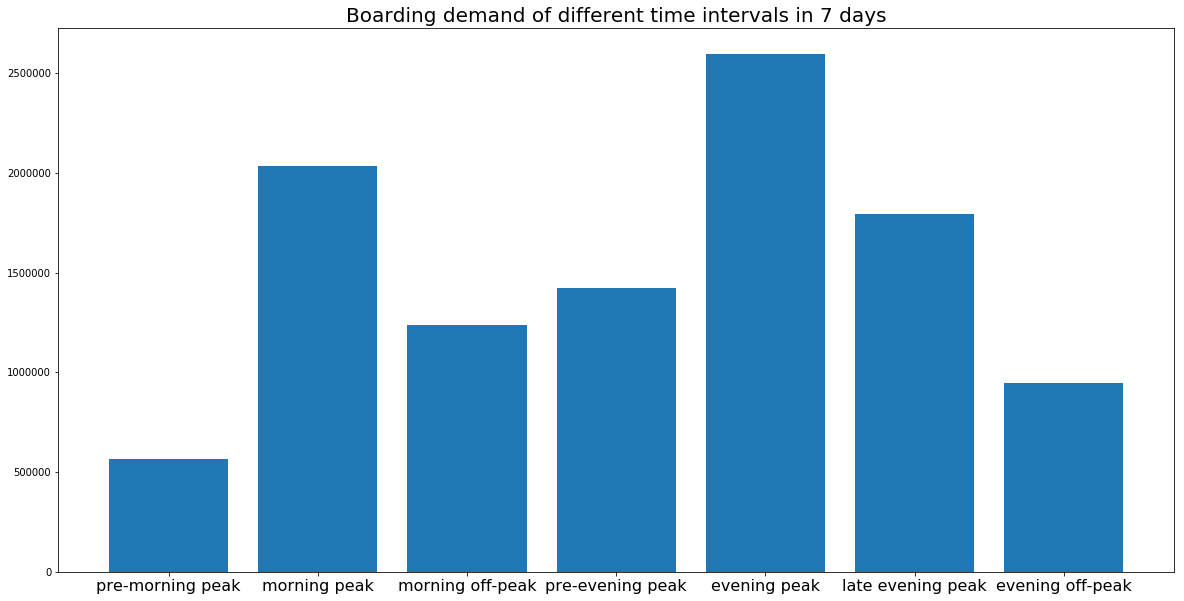

In [61]:
fig,ax=plt.subplots()
ax.bar(['pre-morning peak', 'morning peak', 'morning off-peak', 'pre-evening peak', 'evening peak', 'late evening peak', 'evening off-peak'],
      [1128385/2, 6099451/3, 7432767/6, 1423293/1, 5192405/2, 5386369/3, 1893754/2])
ax.set_xticklabels(['pre-morning peak', 'morning peak', 'morning off-peak', 'pre-evening peak', 'evening peak', 'late evening peak', 'evening off-peak'],fontdict={'size':16})
plt.title('Boarding demand of different time intervals in 7 days',fontdict={'size':20})
plt.savefig('aver_flow.png')

# Clustering

## Compare the clustering results of latent vectors with different clustering algorithms

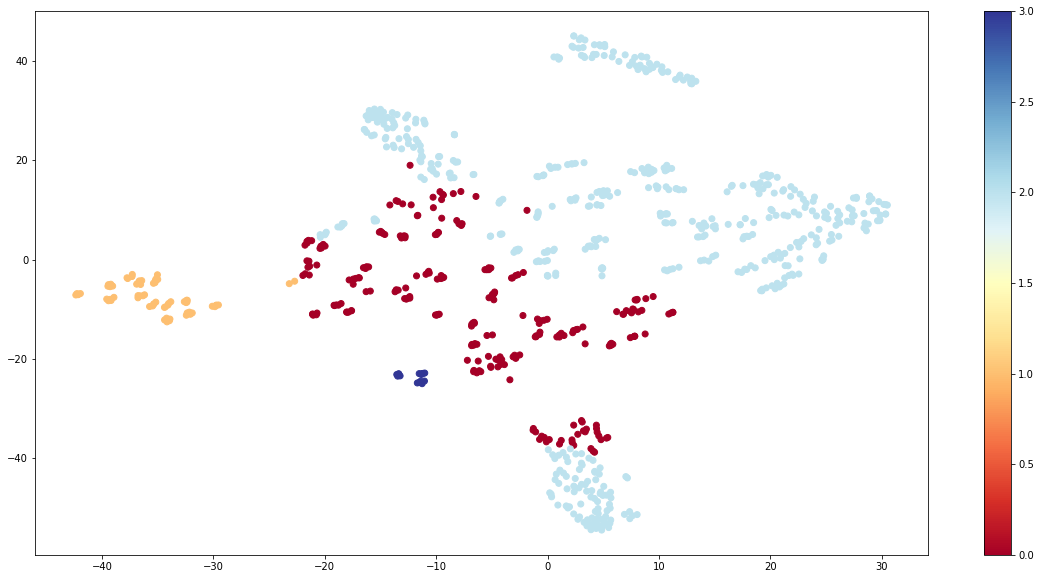

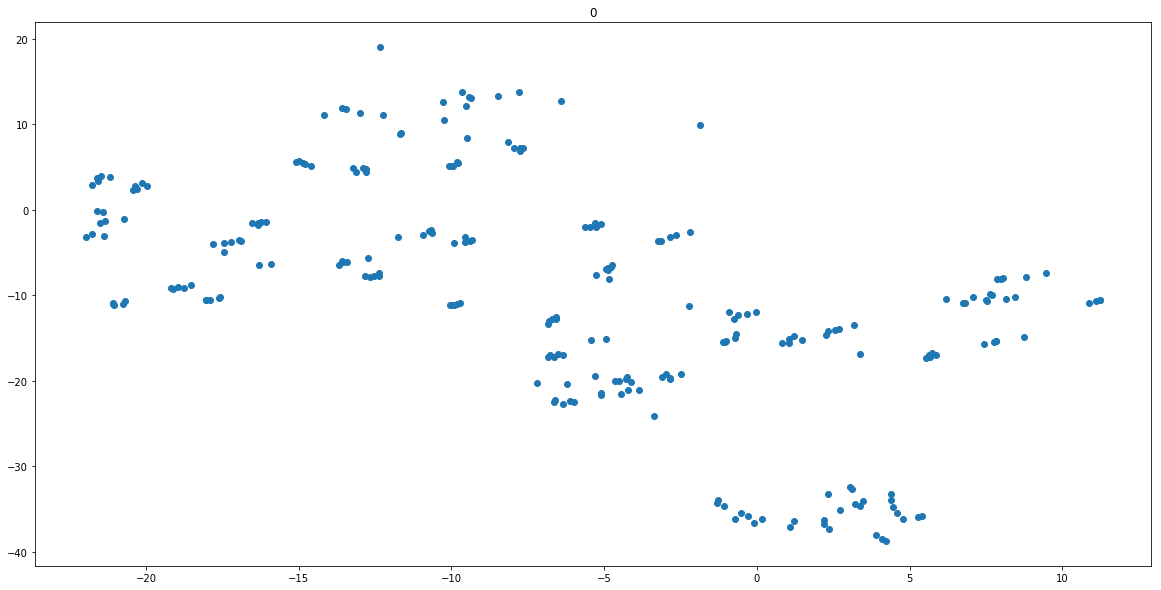

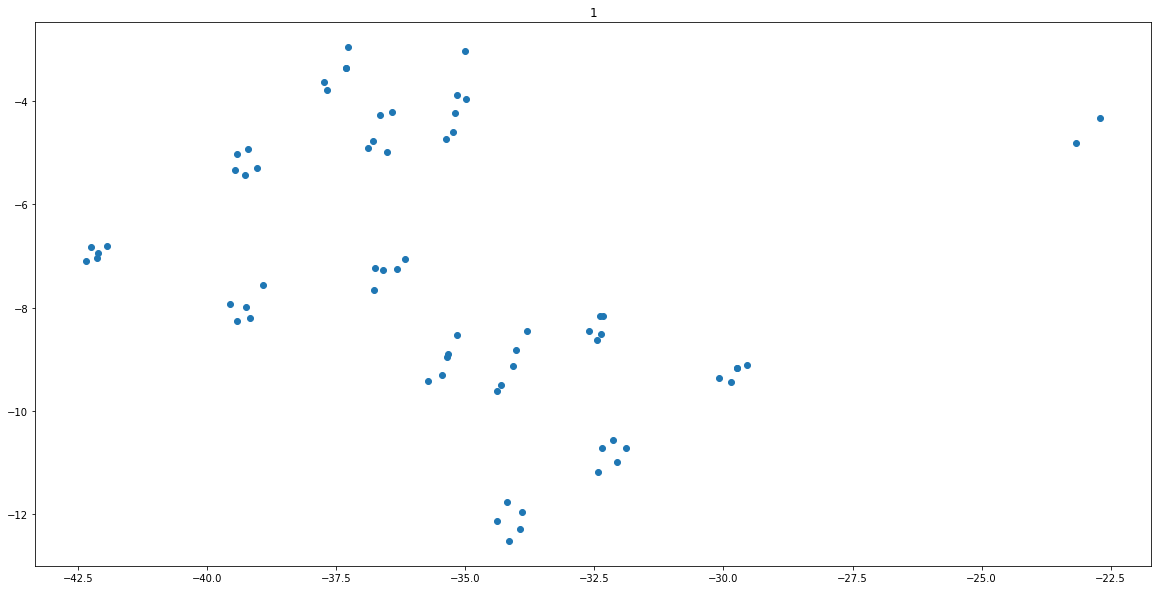

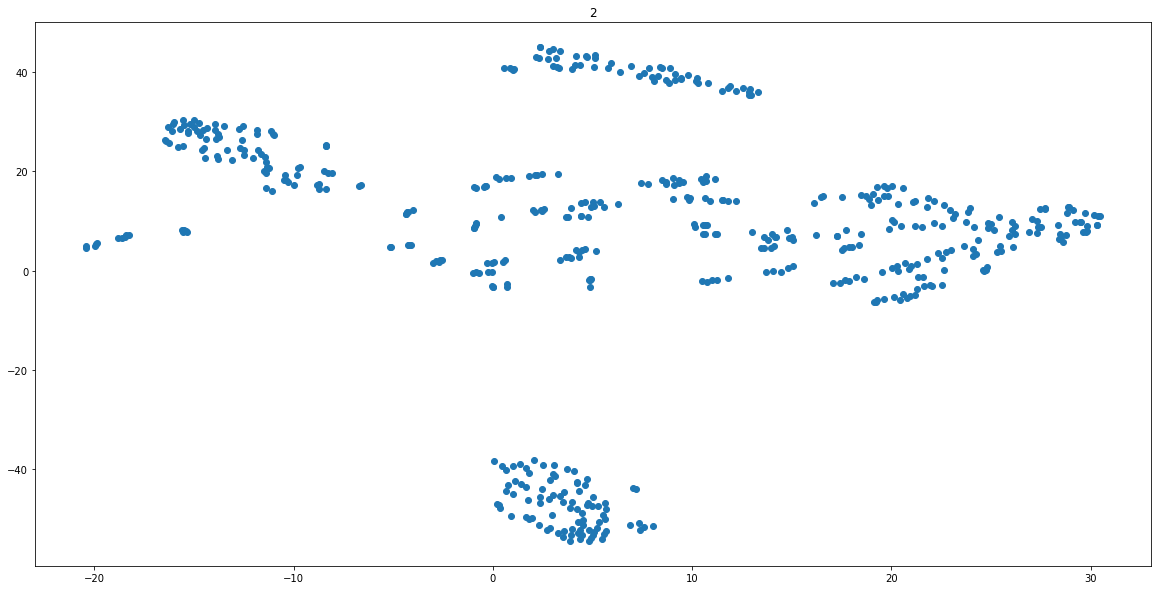

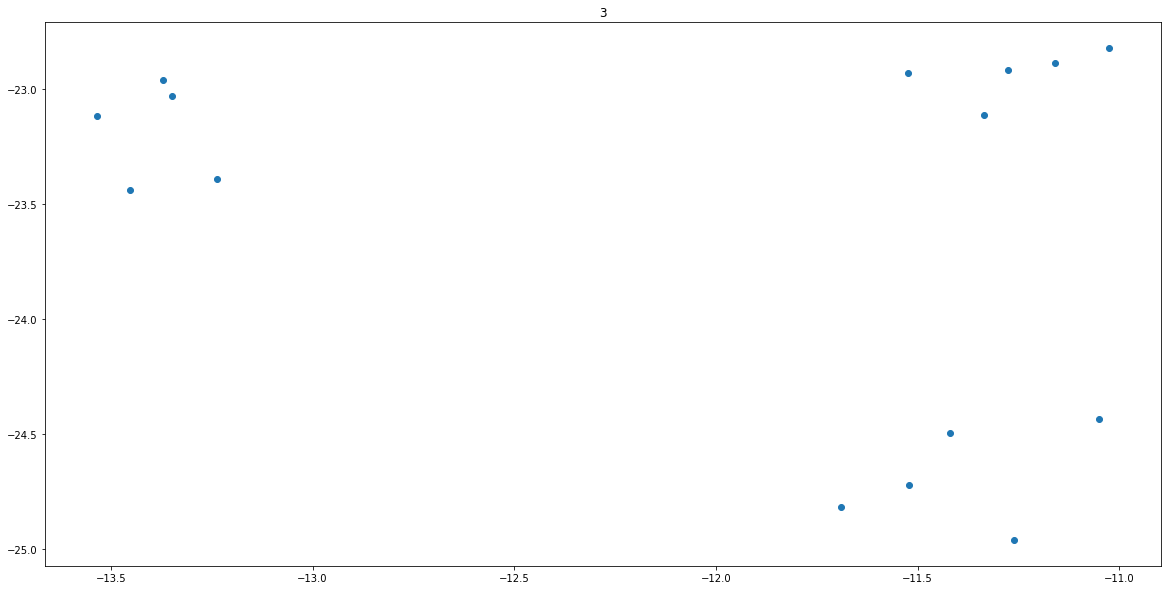

0.38543138
-0.15287173
583.1149000242111


In [63]:
encoded_tint_0=encoder_tint_0.predict(train_data_tint_0)
tint_n_clusters=4
tint_linkage='ward'
tint_affinity='euclidean'
agglo=sklearn.cluster.AgglomerativeClustering(n_clusters=tint_n_clusters,linkage=tint_linkage,affinity=tint_affinity)
labels_tint_0=agglo.fit_predict(encoded_tint_0)
tsne_tint_0=TSNE(n_components=2,learning_rate=100).fit_transform(encoded_tint_0)

plt.figure(7)
plt.scatter(tsne_tint_0[:,0],tsne_tint_0[:,1],c=labels_tint_0,cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar()
figname='../model_0801/tint_0-clusters_'+str(tint_n_clusters)+'-link_'+tint_linkage+'_affin_'+tint_affinity+'.pdf'
plt.savefig(figname)
plt.show()
#f,a=plt.subplots(1,6,figsize=(5,5))
for i in range(tint_n_clusters):
    plt.figure(i)
    lb=labels_tint_0==i
    plt.scatter(tsne_tint_0[lb,0],tsne_tint_0[lb,1])
    plt.title(str(i))
plt.show()
# Silhouette score
print(sklearn.metrics.silhouette_score(encoded_tint_0,labels_tint_0,metric='euclidean'))
print(sklearn.metrics.silhouette_score(encoded_tint_0,labels_tint_0,metric='cosine'))
print(sklearn.metrics.calinski_harabaz_score(encoded_tint_0,labels_tint_0))

## POI clustering

C:\Software\Programming\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


22
1


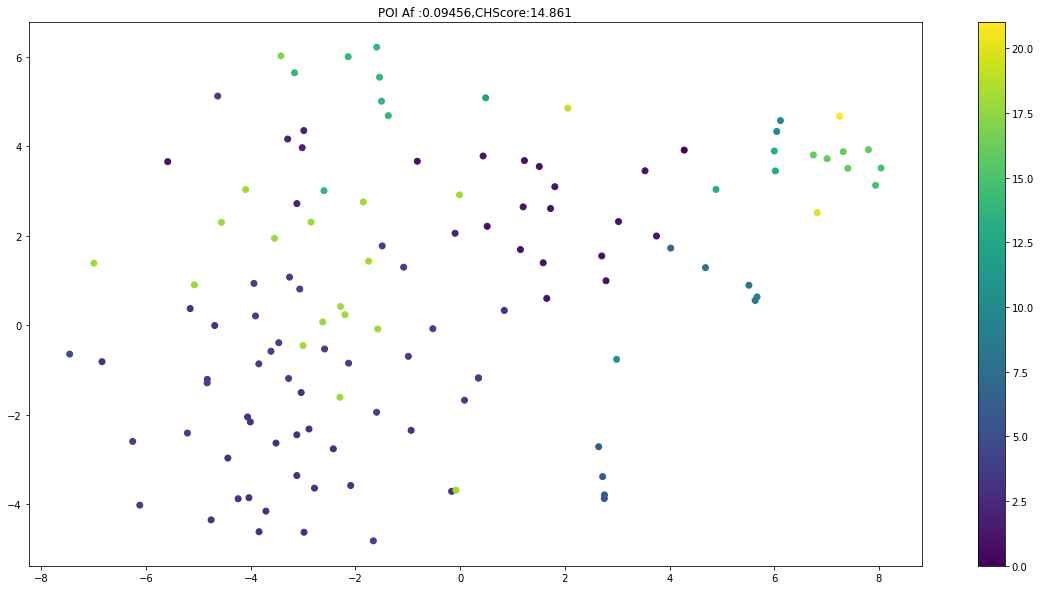

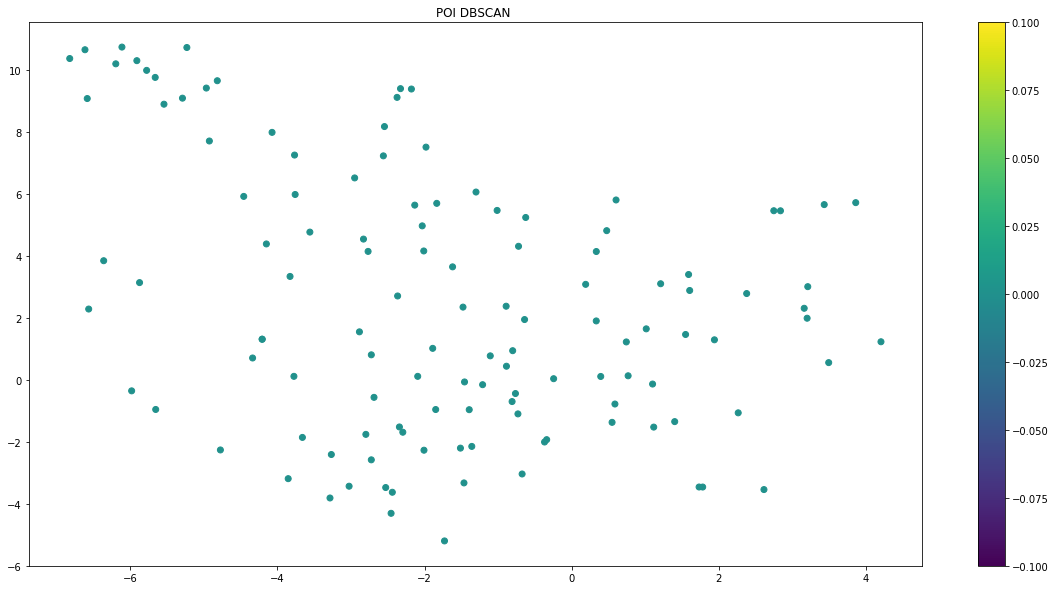

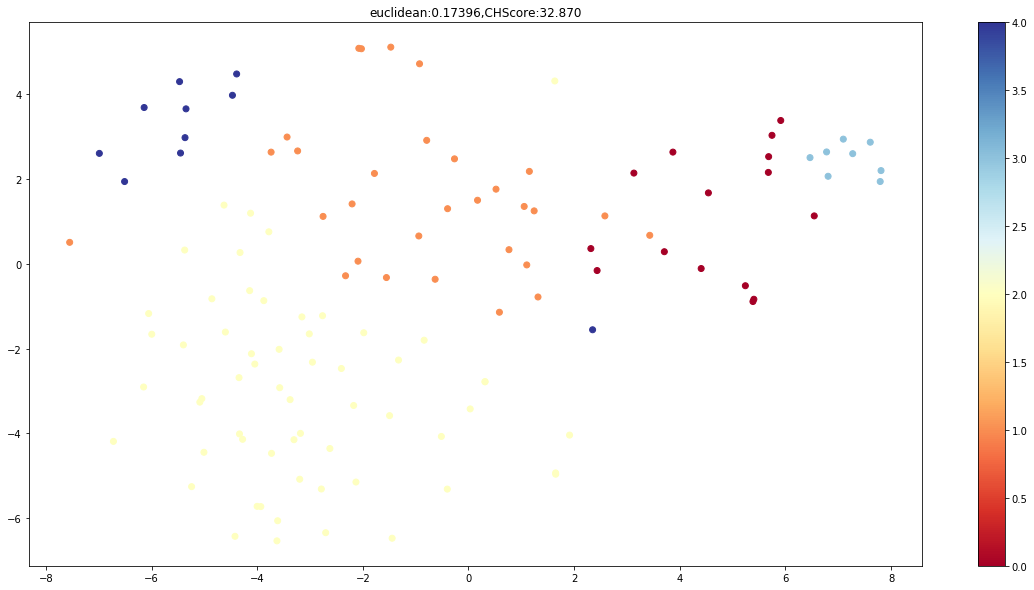

In [67]:
# Use different kinds of clutering 
# Affinity propagation
scaler_poi=sklearn.preprocessing.MinMaxScaler()
scaler_poi.fit(poi_mat)
poi_mat_norm=scaler_poi.transform(poi_mat)
af=sklearn.cluster.AffinityPropagation()
poi_labels=af.fit_predict(poi_mat_norm)
print(len(list(set(poi_labels))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_mat_norm)
plt.figure(0)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_labels)
plt.title('POI Af :{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_mat_norm,poi_labels),
                                                       sklearn.metrics.calinski_harabaz_score(poi_mat_norm,poi_labels)))
plt.colorbar()
plt.savefig('../fig/poi_new_af_default.pdf')
# DBSCAN
db=sklearn.cluster.DBSCAN(metric='cosine',min_samples=1)
poi_labels_db=db.fit_predict(poi_mat_norm)
print(len(list(set(poi_labels_db))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_mat_norm)
plt.figure(1)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_labels_db)
plt.title('POI DBSCAN ')
plt.colorbar()
plt.savefig('../fig/poi_new_dbscan_cosine_min5.pdf')
# AgglomerativeClustering
tint_n_clusters=5
tint_linkage='ward'
tint_affinity='euclidean'
agglo=sklearn.cluster.AgglomerativeClustering(n_clusters=tint_n_clusters,linkage=tint_linkage,affinity=tint_affinity)
poi_labels_agg=agglo.fit_predict(np.row_stack(poi_mat_norm))
tsne_tint_1=TSNE(n_components=2,learning_rate=100).fit_transform(poi_mat_norm)

plt.figure(2)
plt.scatter(tsne_tint_1[:,0],tsne_tint_1[:,1],c=poi_labels_agg,cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar()
plt.title(tint_affinity+':{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_mat_norm,poi_labels_agg,metric=tint_affinity),
                                                       sklearn.metrics.calinski_harabaz_score(poi_mat_norm,poi_labels_agg)))
figname='../fig/poi_new_agg_clusters_'+str(tint_n_clusters)+'-link_'+tint_linkage+'_affin_'+tint_affinity+'.pdf'
plt.savefig(figname)
plt.show()

## Semantic comparison between intersected stations with flow info

If our semantic transferring works, we can get the results that the transaction of "King-Queen=Man-Woman" can also be implemented in our model. Considering tint&day are also features of the word(i.e. stations), comparision within and between them can also be considered as the transcation proof. Besides, the comparison of interesting stations, like transaction stations can also be mined

procedures:
1. Within-Between tint&day explaination (already done?)
2. Interseted stations analysis

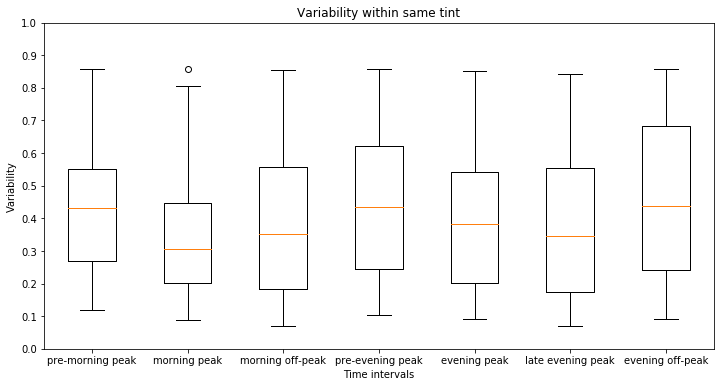

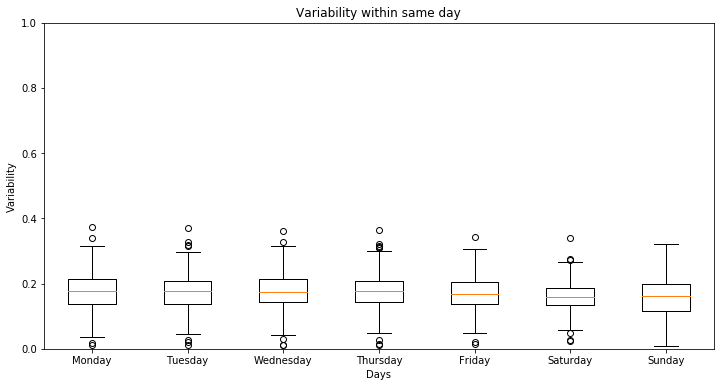

In [70]:
# Boxplot for 122 stations between different tint and days ACCORDINGLY! (2 graphs, for 7 tints & 7 days )
# To be more convinced, for each station of specific boxplot, we only consider its max variation

# For different tint, we draw boxplot for variability defined before
vari_tint=[]
for i in range(7):
    vari_tint_tmp=[]
    for j in range(122): 
        idx=list(range(j,854,122)) # Index for station in different days
        eq0='tmp=train_data_tint_'+str(i)+'[idx]'
        exec(eq0)
        tmp_sim_cos=sklearn.metrics.pairwise.cosine_distances(tmp) # cos_distance is defined as 1.0 minus the cosine similarity.
        vari_tint_tmp.append(np.mean(tmp_sim_cos))
    vari_tint.append(vari_tint_tmp)

plt.rcParams['figure.figsize'] = (12,6)
fig,ax=plt.subplots()
ax.boxplot(vari_tint)
ax.set_ylim(0,1)
ax.set_title('Variability within same tint')
ax.set_xticklabels(list(tint_dict.values()))
ax.set_xlabel('Time intervals')
ax.set_ylabel('Variability')
ax.set_yticks(np.linspace(0,1,11))
plt.savefig('../fig/vari_same_stn_within_same_train_tint.pdf')
plt.savefig('../fig/vari_same_stn_within_same_train_tint.png')
# For different days, draw boxplots for variability
vari_day=[]
for i in range(7):
    vari_day_tmp=[]
    for j in range(122):
        idx=j+i*122
        tmp=[]
        for t in range(7): # 7 tint
            eq1='tmp.append(list(train_data_tint_'+str(t)+'[idx]))'
            exec(eq1)
        tmp_sim_cos=sklearn.metrics.pairwise.cosine_distances(tmp) # cos_distance is defined as 1.0 minus the cosine similarity.
        vari_day_tmp.append(np.mean(tmp_sim_cos))
    vari_day.append(vari_day_tmp)
fig,ax=plt.subplots()
ax.boxplot(vari_day)
ax.set_ylim(0,1)
ax.set_title('Variability within same day')
ax.set_xticklabels(list(day_dict.values()))
ax.set_xlabel('Days')
ax.set_ylabel('Variability')
plt.savefig('../fig/vari_same_stn_within_same_train_day.pdf')
plt.savefig('../fig/vari_same_stn_within_same_train_day.png')


The boxplots have reflected that varaitions in the same tint are prety small across days while variations in the same day are quite large across different tints. This could only serve as the confirmation that ,well, our model partly satisfies our intuition and knowledge of flow information

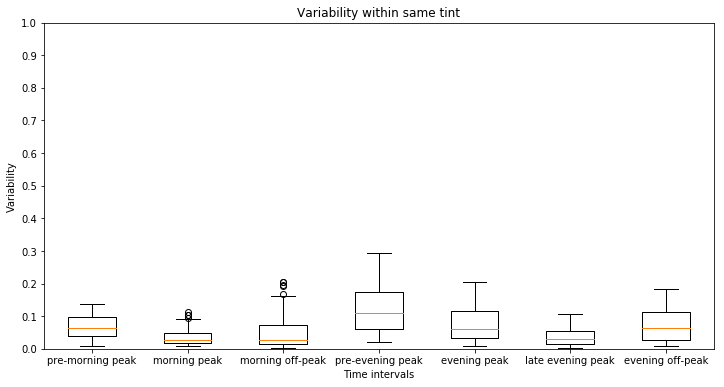

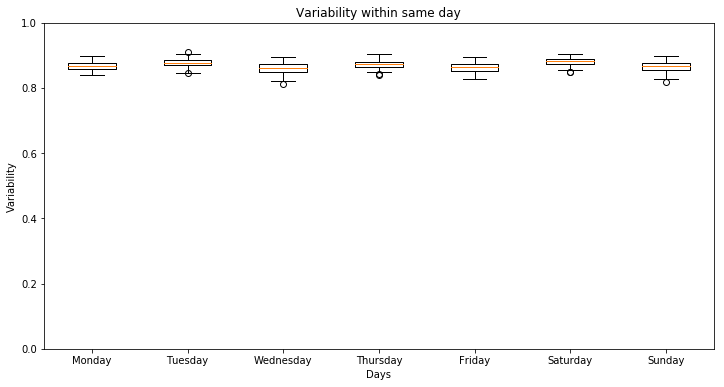

In [71]:
# Boxplot for 122 stations between different tint and days ACCORDINGLY! (2 graphs, for 7 tints & 7 days )
# To be more convinced, for each station of specific boxplot, we only consider its max variation

# For different tint, we draw boxplot for variability defined before
vari_tint=[]
for i in range(7):
    vari_tint_tmp=[]
    for j in range(122): 
        idx=list(range(j,854,122)) # Index for station in different days
        eq0='tmp=encoded_tint_'+str(i)+'[idx]'
        exec(eq0)
        tmp_sim_cos=sklearn.metrics.pairwise.cosine_distances(tmp) # cos_distance is defined as 1.0 minus the cosine similarity.
        vari_tint_tmp.append(np.mean(tmp_sim_cos))
    vari_tint.append(vari_tint_tmp)

plt.rcParams['figure.figsize'] = (12,6)
fig,ax=plt.subplots()
ax.boxplot(vari_tint)
ax.set_ylim(0,1)
ax.set_title('Variability within same tint')
ax.set_xticklabels(list(tint_dict.values()))
ax.set_xlabel('Time intervals')
ax.set_ylabel('Variability')
ax.set_yticks(np.linspace(0,1,11))
plt.savefig('../fig/vari_same_stn_within_tint.pdf')
plt.savefig('../fig/vari_same_stn_within_tint.png')
# For different days, draw boxplots for variability
vari_day=[]
for i in range(7):
    vari_day_tmp=[]
    for j in range(122):
        idx=j+i*122
        tmp=[]
        for t in range(7): # 7 tint
            eq1='tmp.append(list(encoded_tint_'+str(t)+'[idx]))'
            exec(eq1)
        tmp_sim_cos=sklearn.metrics.pairwise.cosine_distances(tmp) # cos_distance is defined as 1.0 minus the cosine similarity.
        vari_day_tmp.append(np.mean(tmp_sim_cos))
    vari_day.append(vari_day_tmp)
fig,ax=plt.subplots()
ax.boxplot(vari_day)
ax.set_ylim(0,1)
ax.set_title('Variability within same day')
ax.set_xticklabels(list(day_dict.values()))
ax.set_xlabel('Days')
ax.set_ylabel('Variability')
plt.savefig('../fig/vari_same_stn_within_day.pdf')
plt.savefig('../fig/vari_same_stn_within_day.png')


This seems like the encoded vector can present much more semantic representation. Just use heat map to represent our results, anyway, it is not a abnormal choice.

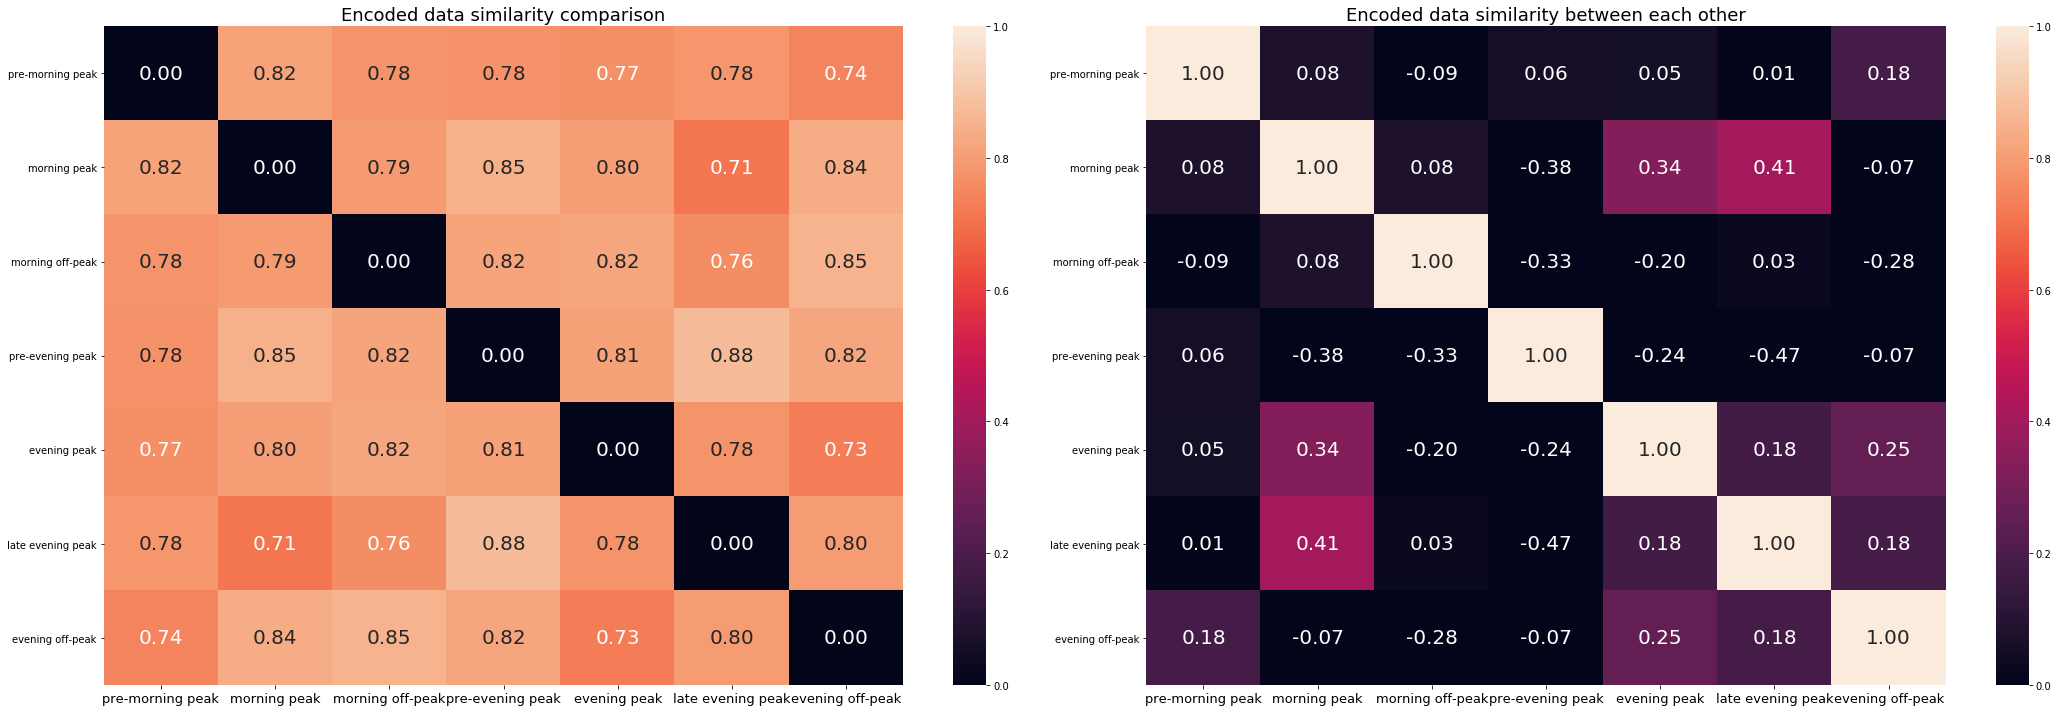

In [74]:
encoded_tint_abstract_mat=np.zeros((7,7))
train_data_tint_abstract_mat=np.zeros((7,7))
encoded_tint_abstract_between_mat=np.zeros((7,7))
for i in range(7):
    for j in range(7):
        eq1='sim_en=np.mean(sklearn.metrics.pairwise.cosine_similarity(encoded_tint_'+str(i)+'-encoded_tint_'+str(j)+'))' # 这边不需要是因为相减向量必须每个都满足
        #eq2='sim_tr=np.mean(sklearn.metrics.pairwise.cosine_similarity(train_data_tint_'+str(i)+'-train_data_tint_'+str(j)+'))'
        eq3='sim_be=np.mean(np.diag(sklearn.metrics.pairwise.cosine_similarity(encoded_tint_'+str(i)+',encoded_tint_'+str(j)+')))' #这边加diag是保证一一对应的关系
        exec(eq1)
        exec(eq3)
        encoded_tint_abstract_mat[i,j]=sim_en
        #train_data_tint_abstract_mat[i,j]=sim_tr
        encoded_tint_abstract_between_mat[i,j]=sim_be
fig,axes=plt.subplots(1,2,figsize=(30,10))
ax_en=sns.heatmap(encoded_tint_abstract_mat, annot=True,annot_kws={'size':20}, fmt=".2f",cbar=True,
            ax=axes[0],vmin=0,vmax=1,yticklabels=list(tint_dict.values()))
ax_tr=sns.heatmap(encoded_tint_abstract_between_mat,annot=True,annot_kws={'size':20}, fmt=".2f",cbar=True,
            ax=axes[1],vmin=0,vmax=1,yticklabels=list(tint_dict.values()))
#ax_en.set_xticklabels(list(tint_dict.values()))
#ax_en.set_yticklabels(list(tint_dict.values()))
#plt.xticks(rotation=0)
ax_en.set_xticklabels(list(tint_dict.values()),fontdict={'size':13})
ax_tr.set_xticklabels(list(tint_dict.values()),fontdict={'size':13})

ax_en.set_title('Encoded data similarity comparison',fontdict={'size':18})
ax_tr.set_title('Encoded data similarity between each other',fontdict={'size':18})

fig.tight_layout()

#plt.savefig('fig/statisticResutls/sim_heatmap_en&tr.pdf')
#plt.savefig('fig/statisticResutls/sim_heatmap_en&tr.png')
plt.savefig('../fig/sim_heatmap_en&be.pdf')
plt.savefig('../fig/sim_heatmap_en&be.png')

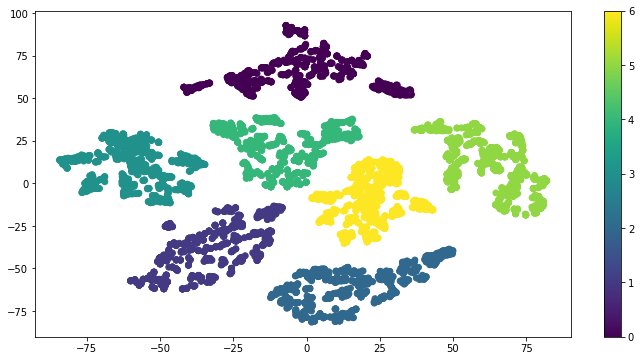

In [75]:
# Use TSNE to explore the similarity, will days or tint can be classified like capitals and countries?

t=encoded_tint_0
for i in range(1,7):
    eq='t=np.row_stack((t,encoded_tint_'+str(i)+'))'
    exec(eq)

tl=np.array([]).reshape(-1,1)
for i in range(7):
    tt=np.array([i]*854).reshape(-1,1)
    tl=np.row_stack((tl,tt))
tl=np.array([int(e[0]) for e in tl])

t_tsne=TSNE(n_components=2,learning_rate=100).fit_transform(t) # Learning rate can be tuned!!!
plt.scatter(t_tsne[:,0],t_tsne[:,1],c=tl)
plt.colorbar()

## TF-IDF and ecoder analysis of POIs

In [76]:
# idf
poi_idf=np.log(len(poi_mat)/np.sum(poi_mat>0,axis=0))
# tf calculation for whole matrix
poi_tf=poi_mat/(np.sum(poi_mat,axis=1))
# tf -idf calculation
poi_tf_idf=np.multiply(poi_tf,poi_idf) # But the IS2FUN paper modify it into +
# saving 
joblib.dump(poi_tf_idf,'poi_tf_idf.asv')

# It seems that the direct clustering results in poor performance, but using autoencoder might introduce 122 identity for the matrix
# we just use SVD as Zhengyu does
svd=sklearn.decomposition.TruncatedSVD(n_components=2, n_iter=20, random_state=42)
poi_tf_idf_svd=svd.fit_transform(poi_tf_idf)
np.shape(poi_tf_idf_svd)

(122, 2)

Use TF-IDF index to condense the information of POI information. This index or factor can better capture the distinct type of each region because the more frequent POI category is the lower tf-idf value will be

14
1


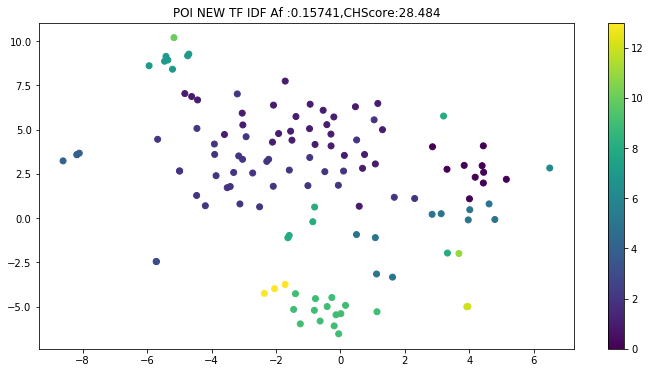

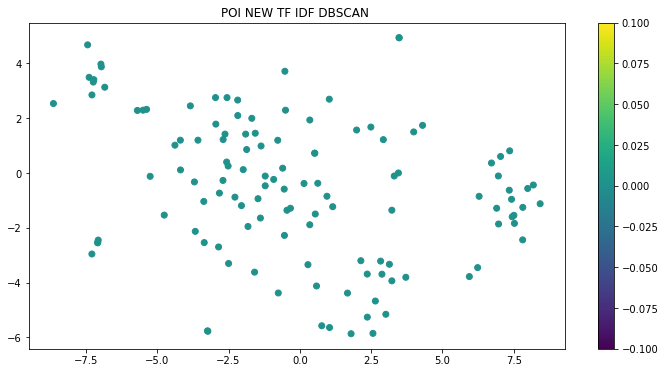

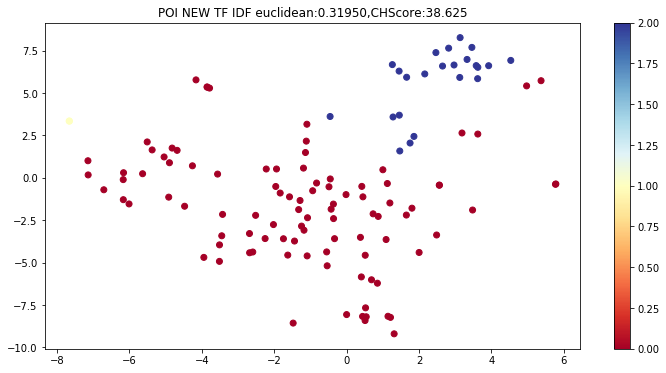

In [77]:
# What is the resutl of clustering on poi_tf_idf
# Use different kinds of clutering 
# Affinity propagation
af=sklearn.cluster.AffinityPropagation()
poi_tf_idf_labels=af.fit_predict(poi_tf_idf)
print(len(list(set(poi_tf_idf_labels))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_tf_idf)
plt.figure(0)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_tf_idf_labels)
plt.title('POI NEW TF IDF Af :{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_tf_idf,poi_tf_idf_labels),
                                                       sklearn.metrics.calinski_harabaz_score(poi_tf_idf,poi_tf_idf_labels)))
plt.colorbar()
#plt.savefig('fig/poi_new_tf_idf_af_default.pdf')
# DBSCAN
db=sklearn.cluster.DBSCAN(metric='cosine',min_samples=1)
poi_tf_idf_labels_db=db.fit_predict(poi_tf_idf)
print(len(list(set(poi_tf_idf_labels_db))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_tf_idf)
plt.figure(1)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_tf_idf_labels_db)
plt.title('POI NEW TF IDF DBSCAN ')
plt.colorbar()
#plt.savefig('fig/poi_new_tf_idf_dbscan_cosine_min5.pdf')
# AgglomerativeClustering
tint_n_clusters=3
tint_linkage='ward'
tint_affinity='euclidean'
agglo=sklearn.cluster.AgglomerativeClustering(n_clusters=tint_n_clusters,linkage=tint_linkage,affinity=tint_affinity)
poi_tf_idf_labels_agg=agglo.fit_predict(np.row_stack(poi_tf_idf))
tsne_tint_1=TSNE(n_components=2,learning_rate=100).fit_transform(poi_tf_idf)

plt.figure(2)
plt.scatter(tsne_tint_1[:,0],tsne_tint_1[:,1],c=poi_tf_idf_labels_agg,cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar()
plt.title('POI NEW TF IDF '+tint_affinity+':{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_tf_idf,poi_tf_idf_labels_agg,metric=tint_affinity),
                                                       sklearn.metrics.calinski_harabaz_score(poi_tf_idf,poi_tf_idf_labels_agg)))
figname='../fig/poi_new_tf_idf_agg_clusters_'+str(tint_n_clusters)+'-link_'+tint_linkage+'_affin_'+tint_affinity+'.pdf'
#plt.savefig(figname)
plt.show()

Exploit SVD before clustering to get a better clustering performance.

Converged after 38 iterations.
13
1


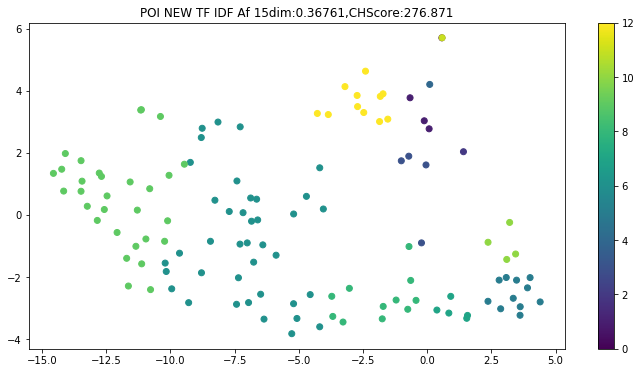

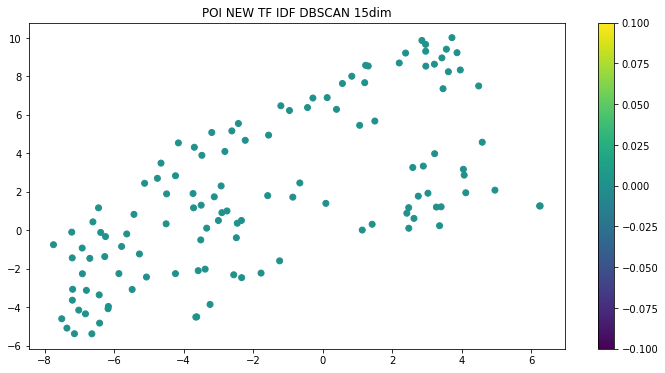

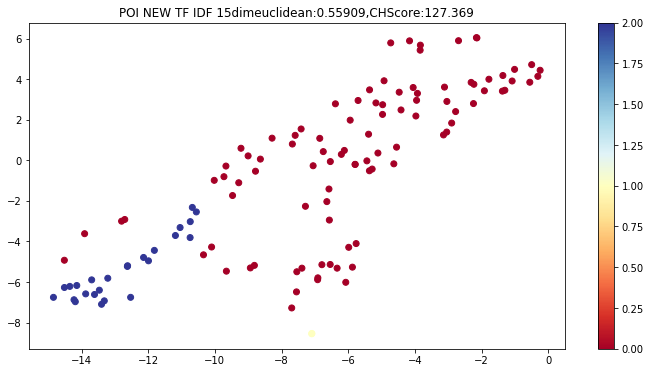

In [80]:
# What is the resutl of clustering on poi_tf_idf_svd
# Use different kinds of clutering 
# Affinity propagation
af=sklearn.cluster.AffinityPropagation(damping=0.5,verbose=True)
poi_tf_idf_svd_labels=af.fit_predict(poi_tf_idf_svd)
print(len(list(set(poi_tf_idf_svd_labels))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_tf_idf_svd)
plt.figure(0)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_tf_idf_svd_labels)
plt.title('POI NEW TF IDF Af 15dim:{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_tf_idf_svd,poi_tf_idf_svd_labels),
                                                       sklearn.metrics.calinski_harabaz_score(poi_tf_idf_svd,poi_tf_idf_svd_labels)))
plt.colorbar()
#plt.savefig('fig/poi_new_0831_tf_idf_svd_15d_damp0.5_af_default.pdf')
# DBSCAN
db=sklearn.cluster.DBSCAN(metric='cosine',min_samples=1)
poi_tf_idf_svd_labels_db=db.fit_predict(poi_tf_idf_svd)
print(len(list(set(poi_tf_idf_svd_labels_db))))
poi_tsne=TSNE(n_components=2,learning_rate=200).fit_transform(poi_tf_idf_svd)
plt.figure(1)
plt.scatter(poi_tsne[:,0],poi_tsne[:,1],c=poi_tf_idf_svd_labels_db)
plt.title('POI NEW TF IDF DBSCAN 15dim')
plt.colorbar()
#plt.savefig('fig/poi_new_0813_tf_idf_svd_15d_dbscan_cosine_min5.pdf')
# AgglomerativeClustering
tint_n_clusters=3
tint_linkage='ward'
tint_affinity='euclidean'
agglo=sklearn.cluster.AgglomerativeClustering(n_clusters=tint_n_clusters,linkage=tint_linkage,affinity=tint_affinity)
poi_tf_idf_svd_labels_agg=agglo.fit_predict(np.row_stack(poi_tf_idf_svd))
tsne_tint_1=TSNE(n_components=2,learning_rate=100).fit_transform(poi_tf_idf_svd)

plt.figure(2)
plt.scatter(tsne_tint_1[:,0],tsne_tint_1[:,1],c=poi_tf_idf_svd_labels_agg,cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar()
plt.title('POI NEW TF IDF 15dim'+tint_affinity+':{:.5f},CHScore:{:.3f}'.format(sklearn.metrics.silhouette_score(poi_tf_idf_svd,poi_tf_idf_svd_labels_agg,metric=tint_affinity),
                                                       sklearn.metrics.calinski_harabaz_score(poi_tf_idf_svd,poi_tf_idf_svd_labels_agg)))
#figname='fig/poi_new_0813_tf_idf_svd_15d_3c_agg_clusters_'+str(tint_n_clusters)+'-link_'+tint_linkage+'_affin_'+tint_affinity+'.pdf'
#plt.savefig(figname)
plt.show()

Affinity Propagation outperforms the other clustering algorithms (**Need more examples for comparison**). Figure out the specific allocation of stations to POI AP clusters.

22
Station list of cluster 1:  (['STN Kallang', 'STN Yio Chu Kang', 'STN Tai Seng'], [['EW'], ['NS'], ['CC']]) 

Station list of cluster 3:  (['STN Paya Lebar', 'STN Aljunied', 'STN Lavender', 'STN Pasir Panjang'], [['EW', 'CC'], ['EW'], ['EW'], ['CC']]) 

Station list of cluster 5:  (['STN Raffles Place', 'STN Somerset', 'STN Dhoby Ghaut', 'STN Chinatown', 'STN Outram Park', 'STN Bras Basah', 'STN City Hall', 'STN Orchard', 'STN Clarke Quay', 'STN Promenade', 'STN Esplanade'], [['NS', 'EW'], ['NS'], ['NS', 'NE', 'CC'], ['NE'], ['EW', 'NE'], ['CC'], ['NS', 'EW'], ['NS'], ['NE'], ['CC'], ['CC']]) 

Station list of cluster 6:  (['STN Bukit Panjang', 'STN Bedok', 'STN Choa Chu Kang', 'STN Pioneer', 'STN Ang Mo Kio', 'STN Woodlands', 'STN Boon Keng', 'STN Lakeside', 'STN Boon Lay', 'STN Bukit Batok', 'STN Hougang', 'STN Yishun', 'STN Phoenix', 'STN Simei', 'STN Tanah Merah', 'STN Tiong Bahru', 'STN Sengkang', 'STN Petir', 'STN Bukit Gombak', 'STN Khatib', 'STN Bakau', 'STN Punggol', 'STN D

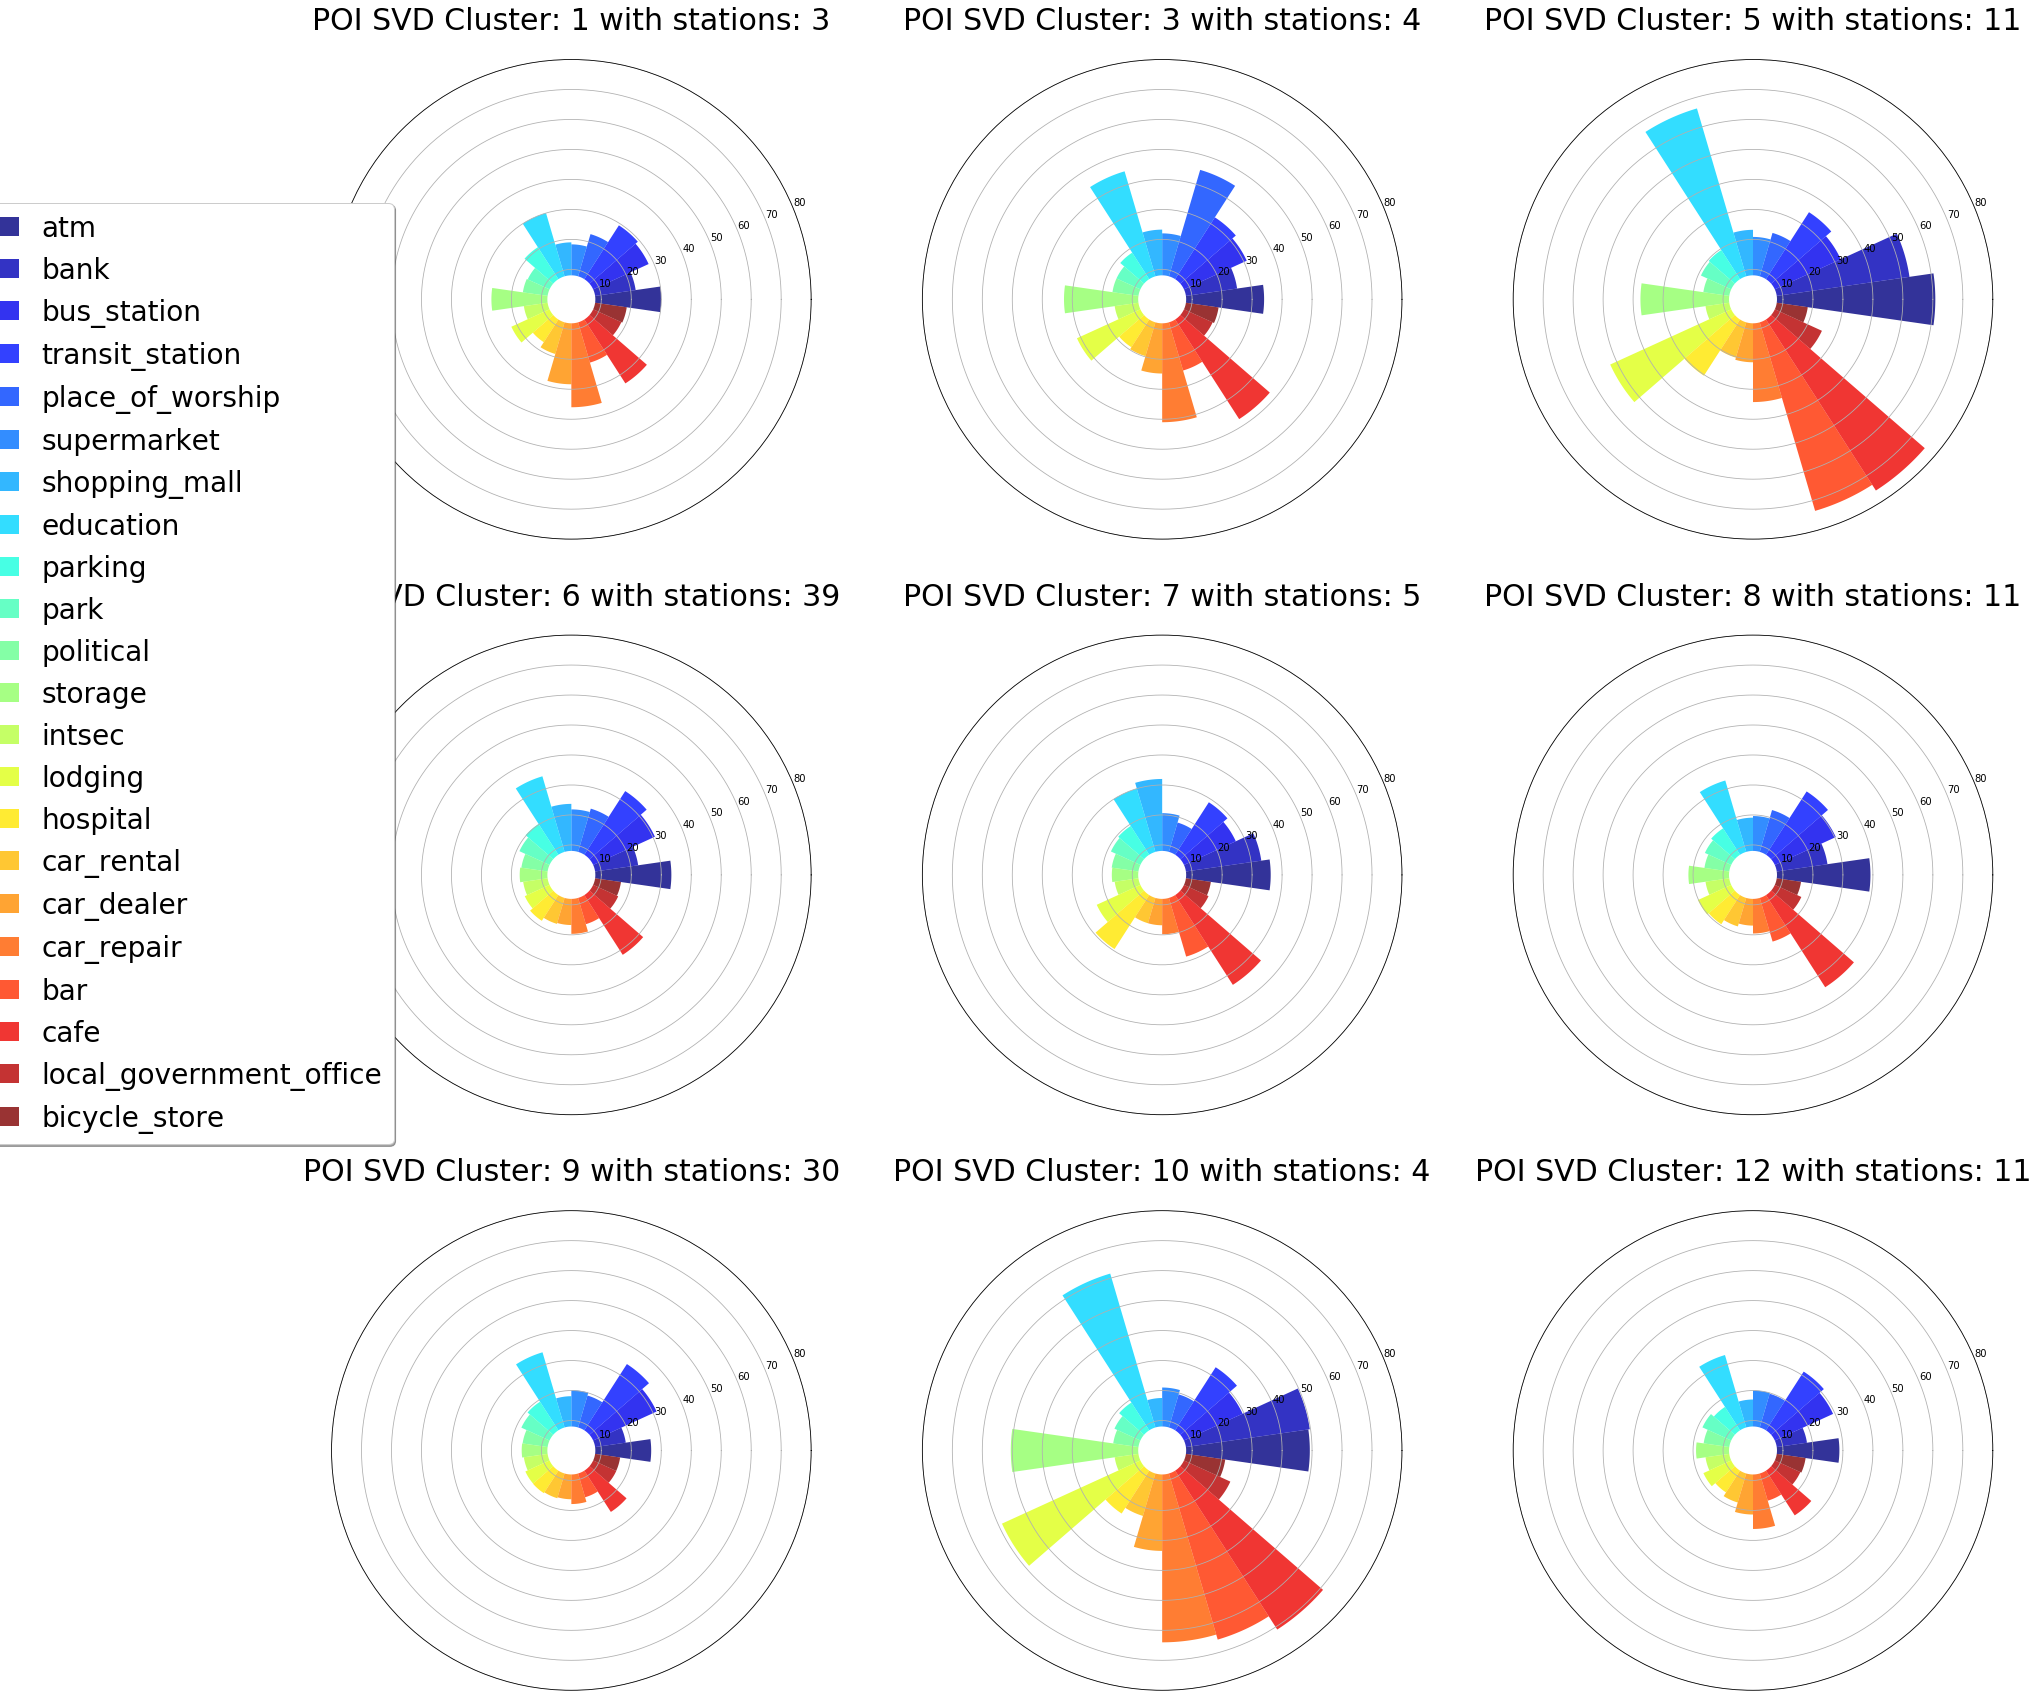

In [82]:
# What is the distribution of different POIs clusters from AF results?
print(np.shape(poi_mat)[1])
bottom = 8
N=len(poi_selected)
theta = np.linspace(0.0, 2 * np.pi, N , endpoint=False)
width = (2*np.pi) / (N)

#subplts=int(str(int(np.ceil(cnt/2)))+'21')
#ax = plt.subplot(111, polar=True)
#ax = plt.subplot(nrows=10,ncols=1, polar=True)

fig=plt.figure(0,figsize=(30,30))
subplts=331
for i in range(len(list(set(poi_tf_idf_svd_labels)))):
    idx=(poi_tf_idf_svd_labels==i)
    if np.sum(idx)>1 :
        #plt.figure(i,figsize=(10,10))
        #c=np.mean(station_POI_Intsec[poi_selected][idx])
        c=np.mean(poi_mat[idx],axis=0)
        c+=bottom
        #plt.bar(range(len(c)),c)
        #plt.xticks(list(range(len(c))),poi_selected)
        ax = plt.subplot(subplts, polar=True)

        bars = ax.bar(theta,c.tolist()[0], width=width, bottom=bottom)
        ax.set_rlim(0,80)
        
        # Use custom colors and opacity
        for r, bar in zip(theta, bars):
            bar.set_facecolor(plt.cm.jet(r/6))
            bar.set_alpha(0.8)
        #ax.legend(bars,poi_selected,loc='upper center', bbox_to_anchor=(0,0.8),  shadow=True)
        #plt.xlabel('POI')
        #plt.ylabel('Mean POI frequency')
        #plt.axis('off')
        ax.grid(True)
        ax.set_xticks([])
        ax.set_title('POI SVD Cluster: '+str(i)+' with stations: '+str(len(getStationNames(np.where(idx)[0])[0])),fontdict={'size':30})
        #plt.title('POI SVD Cluster: '+str(i))
        #plt.savefig('fig/poi_new/poi_svd_sluster {:}.png'.format(i))
        subplts+=1
        print('Station list of cluster {:}: '.format(i),getStationNames(np.where(idx)[0])[1:],'\n')
    else:
        continue
plt.rc('legend',fontsize=28) # using a size in points
#fig.suptitle('POI New SVD clusters')
fig.legend(bars,poi_selected,loc='upper center', bbox_to_anchor=(0.08,0.7),  shadow=True, )
#plt.savefig('fig/poi_new/poi_0825_svd_clusters.png')

## Explain the AF Clustering results with LDA topic modeling method 

In [84]:
def getNLargestIdx(ls,N):
    a=sorted(ls)
    NL=a[-N:]
    res=[]
    ls=np.array(ls)
    for e in NL:
        res.append(np.where(ls==e)[0][0]) 
    return res

lda=sklearn.decomposition.LatentDirichletAllocation(n_components=1)

For cluster 1 with probability & the topic is 
[1.] [array(['car_repair', 'atm', 'bus_station'], dtype='<U23')]
For cluster 3 with probability & the topic is 
[1.] [array(['education', 'cafe', 'storage'], dtype='<U23')]
For cluster 5 with probability & the topic is 
[1.] [array(['education', 'bar', 'cafe'], dtype='<U23')]
For cluster 6 with probability & the topic is 
[1.] [array(['atm', 'transit_station', 'education'], dtype='<U23')]
For cluster 7 with probability & the topic is 
[1.] [array(['bar', 'atm', 'cafe'], dtype='<U23')]
For cluster 8 with probability & the topic is 
[1.] [array(['transit_station', 'atm', 'cafe'], dtype='<U23')]
For cluster 9 with probability & the topic is 
[1.] [array(['bus_station', 'education', 'transit_station'], dtype='<U23')]
For cluster 10 with probability & the topic is 
[1.] [array(['bar', 'cafe', 'car_repair'], dtype='<U23')]
For cluster 12 with probability & the topic is 
[1.] [array(['education', 'bus_station', 'transit_station'], dtype='<U23')]


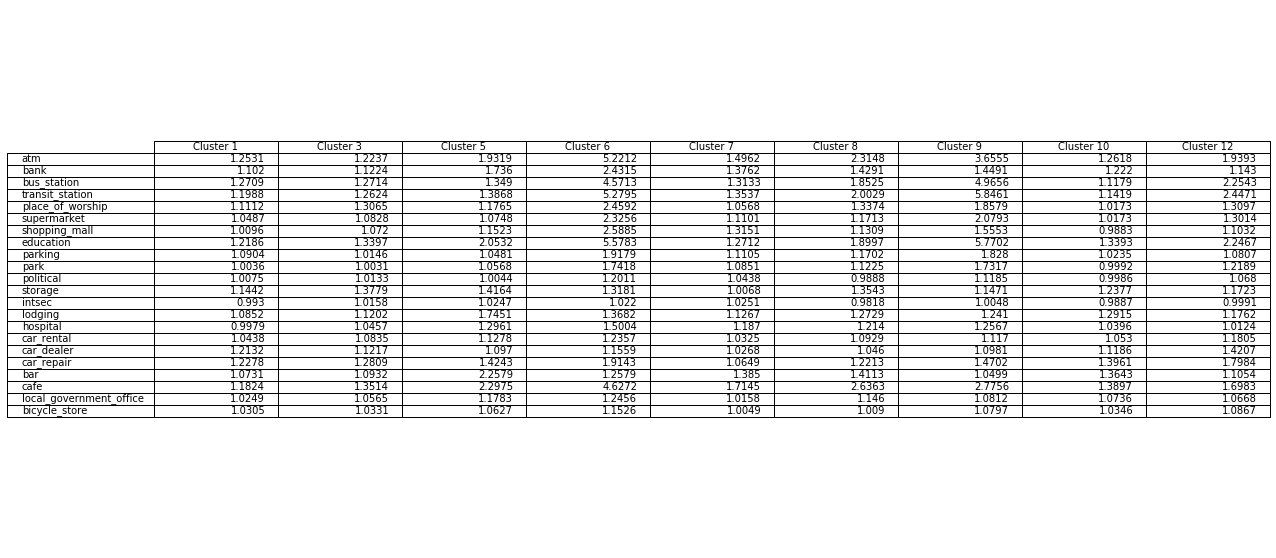

In [97]:
topics=[] # topics for all chosen clusters
row_names=[]
comp=[]
for i in range(len(poi_tf_idf_svd_labels)):
    idx=(poi_tf_idf_svd_labels==i)
    if np.sum(idx)>1:
        row_names.append('Cluster '+str(i))
        topic=lda.fit_transform(poi_tf[idx])
        prob=np.mean(topic,axis=0)
        tmp=[ poi_selected[getNLargestIdx(top_word,3)] for top_word in lda.components_]
        comp.append(lda.components_[0])
        # Consider using tf-idf since the clustering is based on it
        topics.append(tmp)
        #tmp2=[ poi_selected[getNLargestIdx(top_word,2)] for top_word in np.multiply(lda.components_,poi_idf.reshape(1,-1))]
        print('For cluster '+str(i)+ ' with probability & the topic is ')
        print(prob,tmp)
#del tmp
comp=np.array(comp)
comp=comp.T
comp=pd.DataFrame(comp)
tb_cols=['Topic1']
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(row_names)))
ax = plt.subplot(111, frame_on=False)
ax.figure.set_size_inches(20,10)
#ax=plt.figure(figsize=(50,50))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False) 
ax.table(cellText=np.round_(comp.values,decimals=4),rowLabels=poi_selected,colLabels=row_names,loc='center')
#plt.savefig('fig/poi_new/poi_clu_tables.pdf')

Actually, not much useful information is conveyed from the topic modeling results. Specifically, the number is not salient to be interpretable

## Compare the relationship between poi-tf-idf-svd clusters

In [88]:
# Up&Low bound
sim_up=0.99
sim_low=0

def printSimDateTint(np_where_tuple,stn1,stn2,verbose=False): #Input tuple should be 49*49 logical matrix
    res=[]
    abn_res=[]
    if verbose:
        print('For stations {:}-1 and {:}-2 in lines {:}&{:}these date and time fullfill:'.format(stn1,stn2,
                                                                                              getStationLineNames(stationDict_re[stn1]),
                                                                                              getStationLineNames(stationDict_re[stn2])))
    for i in range(len(np_where_tuple[0])):
        tt1=int(np.floor(np_where_tuple[0][i]/7))
        dd1=np_where_tuple[0][i]%7
        tt2=int(np.floor(np_where_tuple[1][i]/7))
        dd2=np_where_tuple[1][i]%7
        ss='{:}-{:}***{:}-{:}'.format(day_dict[dd1],tint_dict[tt1],day_dict[dd2],tint_dict[tt2])       
        res.append(ss)
        if verbose:
            print(ss)
        if (dd1-dd2) | (tt1-tt2):
            abn_res.append(ss)
            if verbose:
                print('#'*15)                
    if verbose:
        print('-'*15)
    return res,abn_res

def printDis_inSameDateTint(np_where_tuple,stn1,stn2,verbose=False): #Input tuple should be 49*49 logical matrix
    res=[]
    for i in range(len(np_where_tuple[0])):
        tt1=int(np.floor(np_where_tuple[0][i]/7))
        dd1=np_where_tuple[0][i]%7
        tt2=int(np.floor(np_where_tuple[1][i]/7))
        dd2=np_where_tuple[1][i]%7
        #print(tt1,tt2,dd1,dd2)
        if (tt1==tt2) : # Must in same day and tint  & (dd1==dd2) 
            ss='{:}-{:}***{:}-{:}'.format(day_dict[dd1],tint_dict[tt1],day_dict[dd2],tint_dict[tt2])       
            res.append(ss)
            if verbose & len(res)>0:
                print(ss)             
    if verbose & len(res)>0:
        print('For stations {:}-1 and {:}-2 the above date and time fullfill:'.format(stn1,stn2))
        print('-'*15)
    return res

def getSplinePoints(longlat1,longlat2,flow_sim_num):
    pair=[longlat1[0],longlat2[0]]
    long_min=np.min(pair)
    long_max=np.max(pair)
    idx_min=np.where(pair==long_min)[0][0]
    idx_max=np.where(pair==long_max)[0][0]
    
    long_new=[long_min,long_max]
    lat_new=[[longlat1[1],longlat2[1]][idx_min],[longlat1[1],longlat2[1]][idx_max]] # Here might complicate the logics
    # Generate one point
    long_new=np.insert(long_new,1,np.mean(long_new))
    lat_new=np.insert(lat_new,1,np.mean(lat_new)*1.01)
    
    long_smooth=np.linspace(long_min,long_max,100+10*flow_sim_num) 
    f=np.poly1d(np.polyfit(long_new,lat_new,4))
    lat_smooth=f(long_smooth)
    return long_smooth,lat_smooth

def plotStationsLines(ax,lgd_flag=True,mksize=6):
    plt.rcParams['figure.figsize'] = (20, 10)
    #fig,ax=plt.subplots()
    lgd=[]
    cnt=1
    for line in MRTLineNames:
        stn_lines=line_stn_dict[line][0]
        stn_line_num=[int(e[2:]) for e in stn_lines ]
        ix=np.argsort(stn_line_num)
        idx=np.array(line_stn_dict[line][1])[ix] #index for MRTStops
        lt=MRTStops['MRTLat'][idx]
        lg=MRTStops['MRTLng'][idx]

        ax.plot(lg,lt,marker='o',markerfacecolor='white',color='black',markersize=mksize)
        #ax.plot(lg,lt,marker='o')
        ax.set_axis_off()
        lgd.append(line)
        cnt+=1
    if lgd_flag:
        ax.legend(lgd)

def plotCluStations(ax,stn_num,color):
        lt=MRTStops['MRTLat'][stn_num]
        lg=MRTStops['MRTLng'][stn_num]
        ax.plot(lg,lt,marker='o',markersize=6,markerfacecolor=color,linewidth=0,markeredgecolor='black')
        ax.set_axis_off()


# Apply clustering and flow similarity network

->Procedures:
1. Iterate POI to find clustered stations 
2. Mark out clustered stations and use white clolor to denote the other stations
3. Allocate the weight of each pair of stations then plot them according to their weights

->Notes:
1. Exclude similar stations in the same ine

A Jupyter Widget

Cluster 0
Cluster 1
Cluster 3
Cluster 6
Cluster 7
Cluster 8
Cluster 9
Cluster 0
Cluster 1



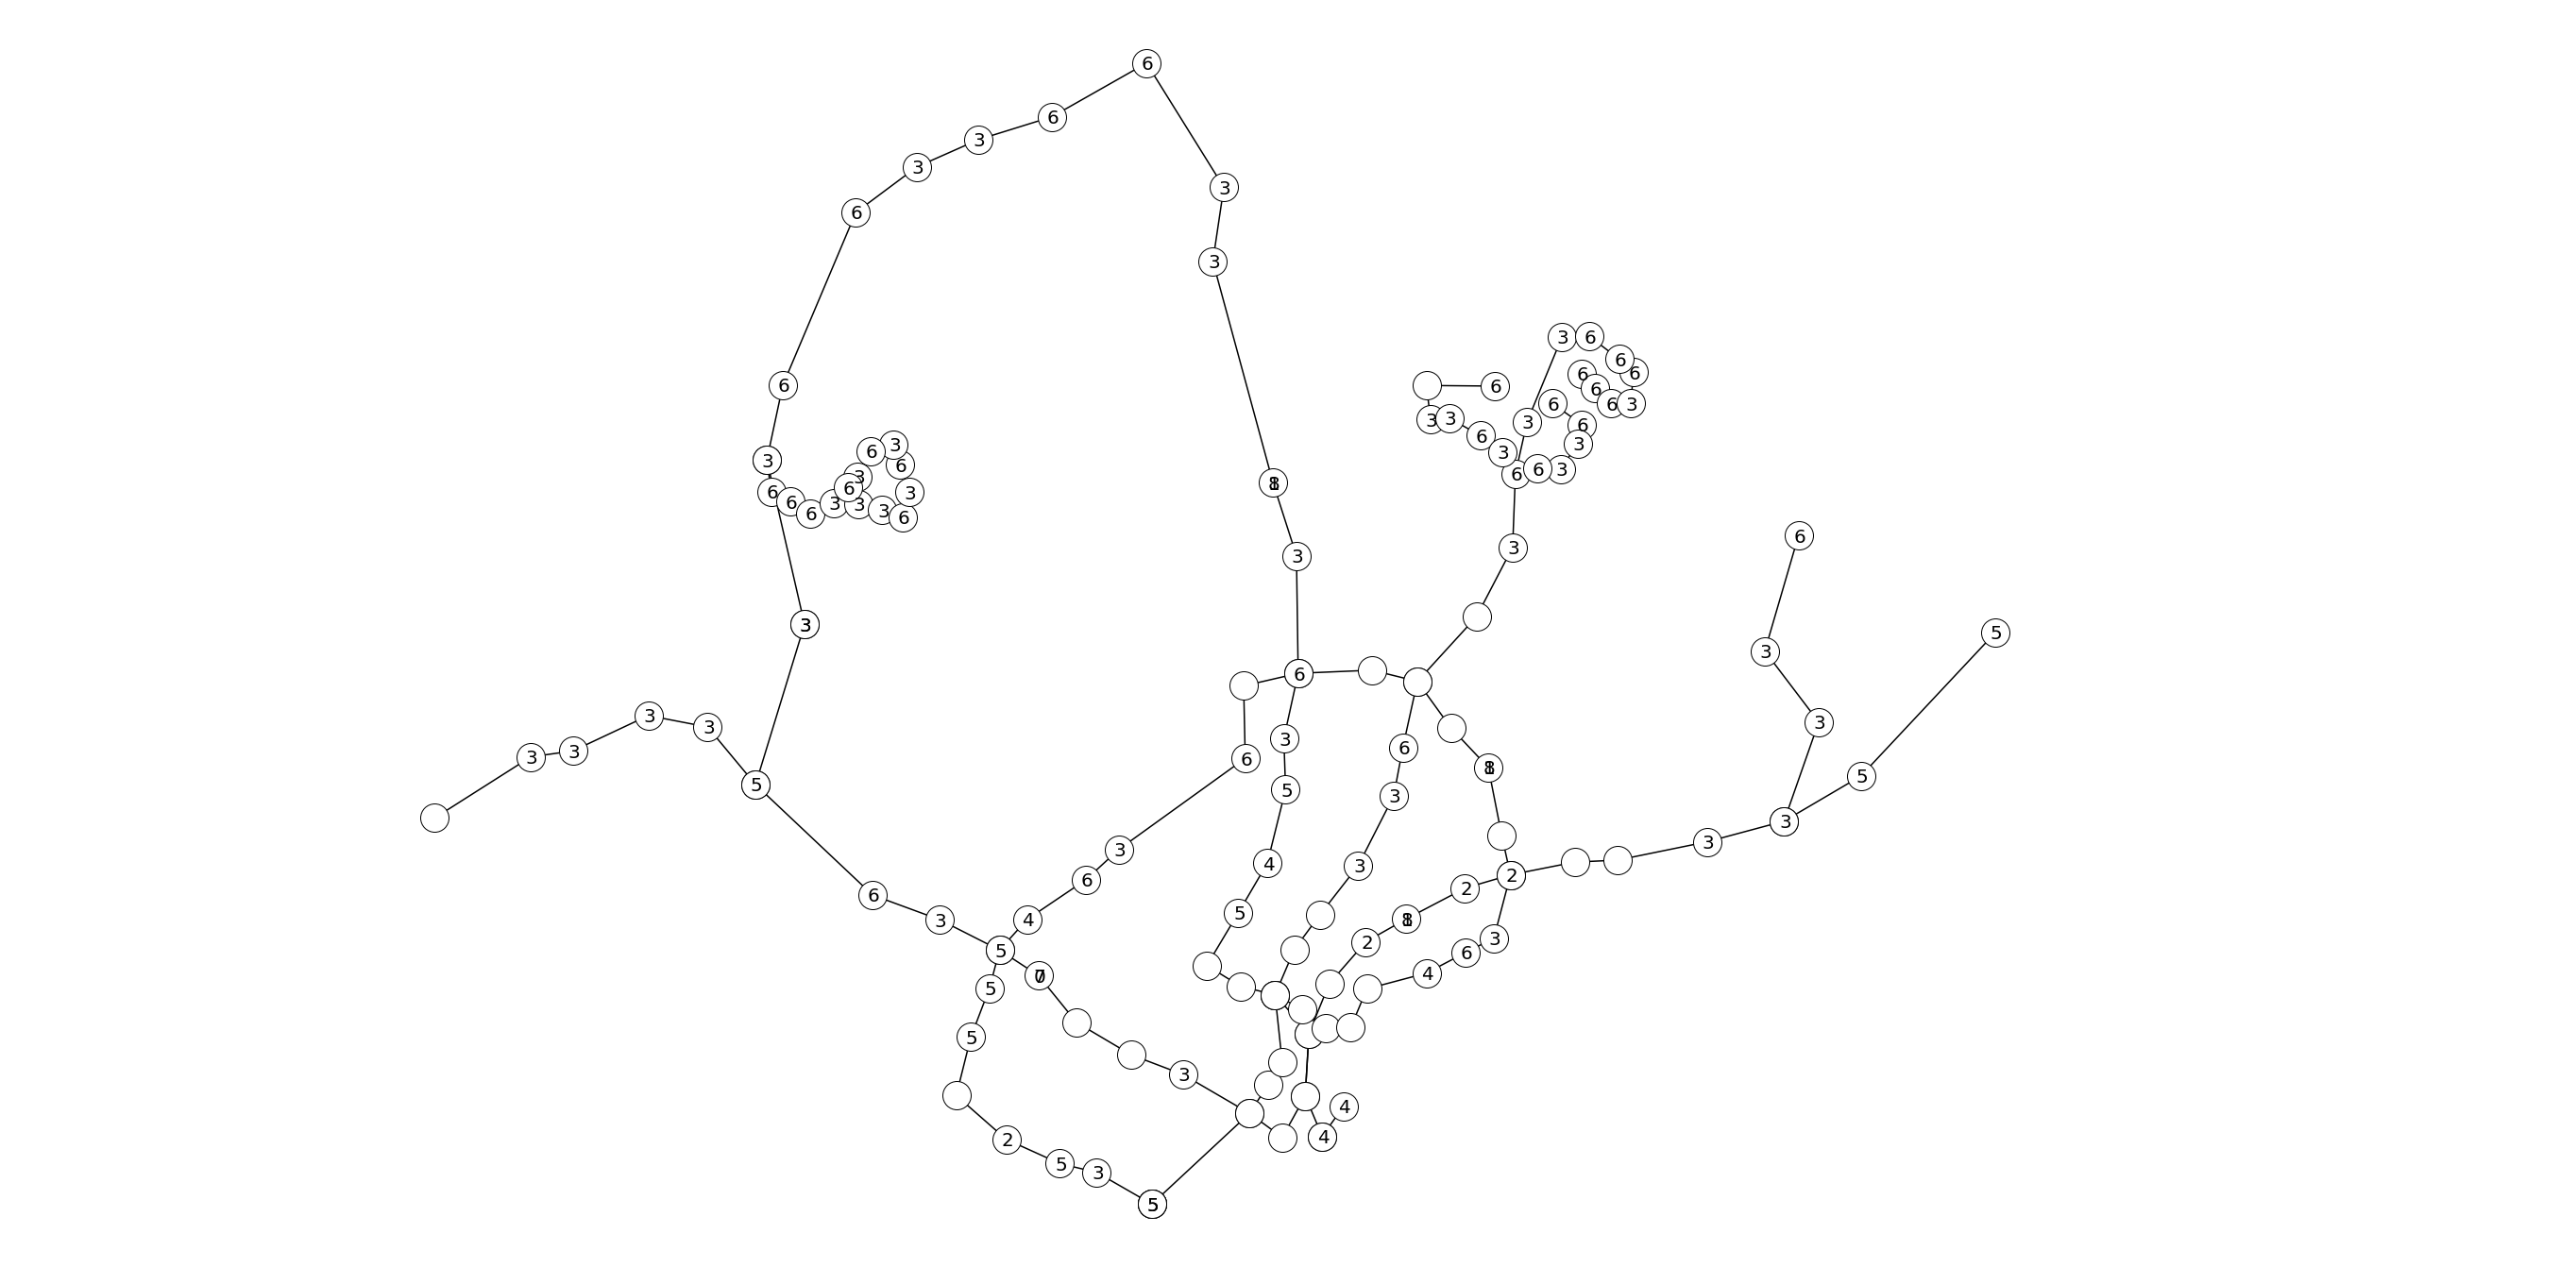

In [91]:
# Revised in 2019/4/21
# Plot poi distribution
fig,ax=plt.subplots(figsize=(38,19))
lb=row_names
mksize=30
deviation=0.001
#lb.append(' ')
plotStationsLines(ax,False,mksize=mksize)

cnt=0
for clu in tqdm_notebook(range(len(poi_tf_idf_svd_clusters))):
#for clu in tqdm_notebook(range(len([0]))):
    print('Cluster',poi_tf_idf_svd_clusters[clu])
    clu_idx=(poi_tf_idf_svd_labels==poi_tf_idf_svd_clusters[clu])
    stns,_,stn_lines=getStationNames(np.where(clu_idx)[0])
    stns_num_1d=[stationDict_re[e] for e in stns]
    # Plot background
    ax.set_xlim(103.6,104.1)
    ax.set_axis_off()

    #plotCluStations(ax,stns_num_1d,color=plt.cm.tab10(cnt))
    lt=MRTStops['MRTLat'][stns_num_1d]
    lg=MRTStops['MRTLng'][stns_num_1d]
    #ax.plot(lg,lt,marker='o',markersize=mksize,markerfacecolor=plt.cm.tab10(cnt),linewidth=0,markeredgecolor='black')
    #ax.plot(lg,lt,marker='o',markersize=mksize,linewidth=0,markeredgecolor='black')
    for t in list(lt.keys()):
        ax.text(lg[t]-deviation,lt[t]-deviation,str(cnt),fontsize=20)
    cnt+=1
    
#ax.legend(plots,row_names,loc='upper center', bbox_to_anchor=(1,1))
#cb_ax = fig.add_axes([0.82, 0.47 , 0.02, 0.4])
#sm = plt.cm.ScalarMappable(cmap=plt.cm.tab10,norm=plt.Normalize(vmin=0,vmax=cnt))
#sm._A=[]
#cbar=fig.colorbar(sm,ax=ax,cax=cb_ax)
#cbar.set_ticks(np.linspace(0,cnt,10))
#cbar.set_ticklabels(lb)


#ax.set_title('POI clusters distribution')
ax.set_axis_off() 
plt.tight_layout()
filename='POI_distribution_nomap_20190421.pdf'
filename2='POI_distribution_nomap_20190421.png'
plt.savefig(filename)
plt.savefig(filename2)

In [ ]:

for clu in tqdm_notebook(range(len(poi_tf_idf_svd_clusters))):
    clu_idx=(poi_tf_idf_labels==poi_tf_idf_svd_clusters[clu])
    stns,_,stn_lines=getStationNames(np.where(clu_idx)[0])
    stns_num=[stationDict_re[e] for e in stns]
    stns_num=[np.arange(e,len(encoded_tint_0),122) for e in stns_num]
    # Got stations, calculate the similarity metrics
    for i in range(len(stns_num)-1):
        for ii in range(i+1,len(stns_num)):
            tmp1=np.array([]).reshape(-1,np.shape(encoded_tint_0)[1])
            tmp2=np.array([]).reshape(-1,np.shape(encoded_tint_0)[1])
            for j in range(7):
                eq1='tmp1=np.row_stack((tmp1,encoded_tint_'+str(j)+'[stns_num[i]]))'
                eq2='tmp2=np.row_stack((tmp2,encoded_tint_'+str(j)+'[stns_num[ii]]))'
                exec(eq1)
                exec(eq2)
            sim_tmp=sklearn.metrics.pairwise.cosine_similarity(tmp1,tmp2) # This should be a 49*49
            a=getStationLineNames(stns_num[i][0])
            b=getStationLineNames(stns_num[ii][0])
            if (sim_tmp>sim_up).any() & ~len(set(a).intersection(set(b))):
                printSimDateTint(np.where(sim_tmp>sim_up),stns[i],stns[ii])
            # Construct 49*16 matrix to calculate the cosine similarity, if any >sim_up, print themb

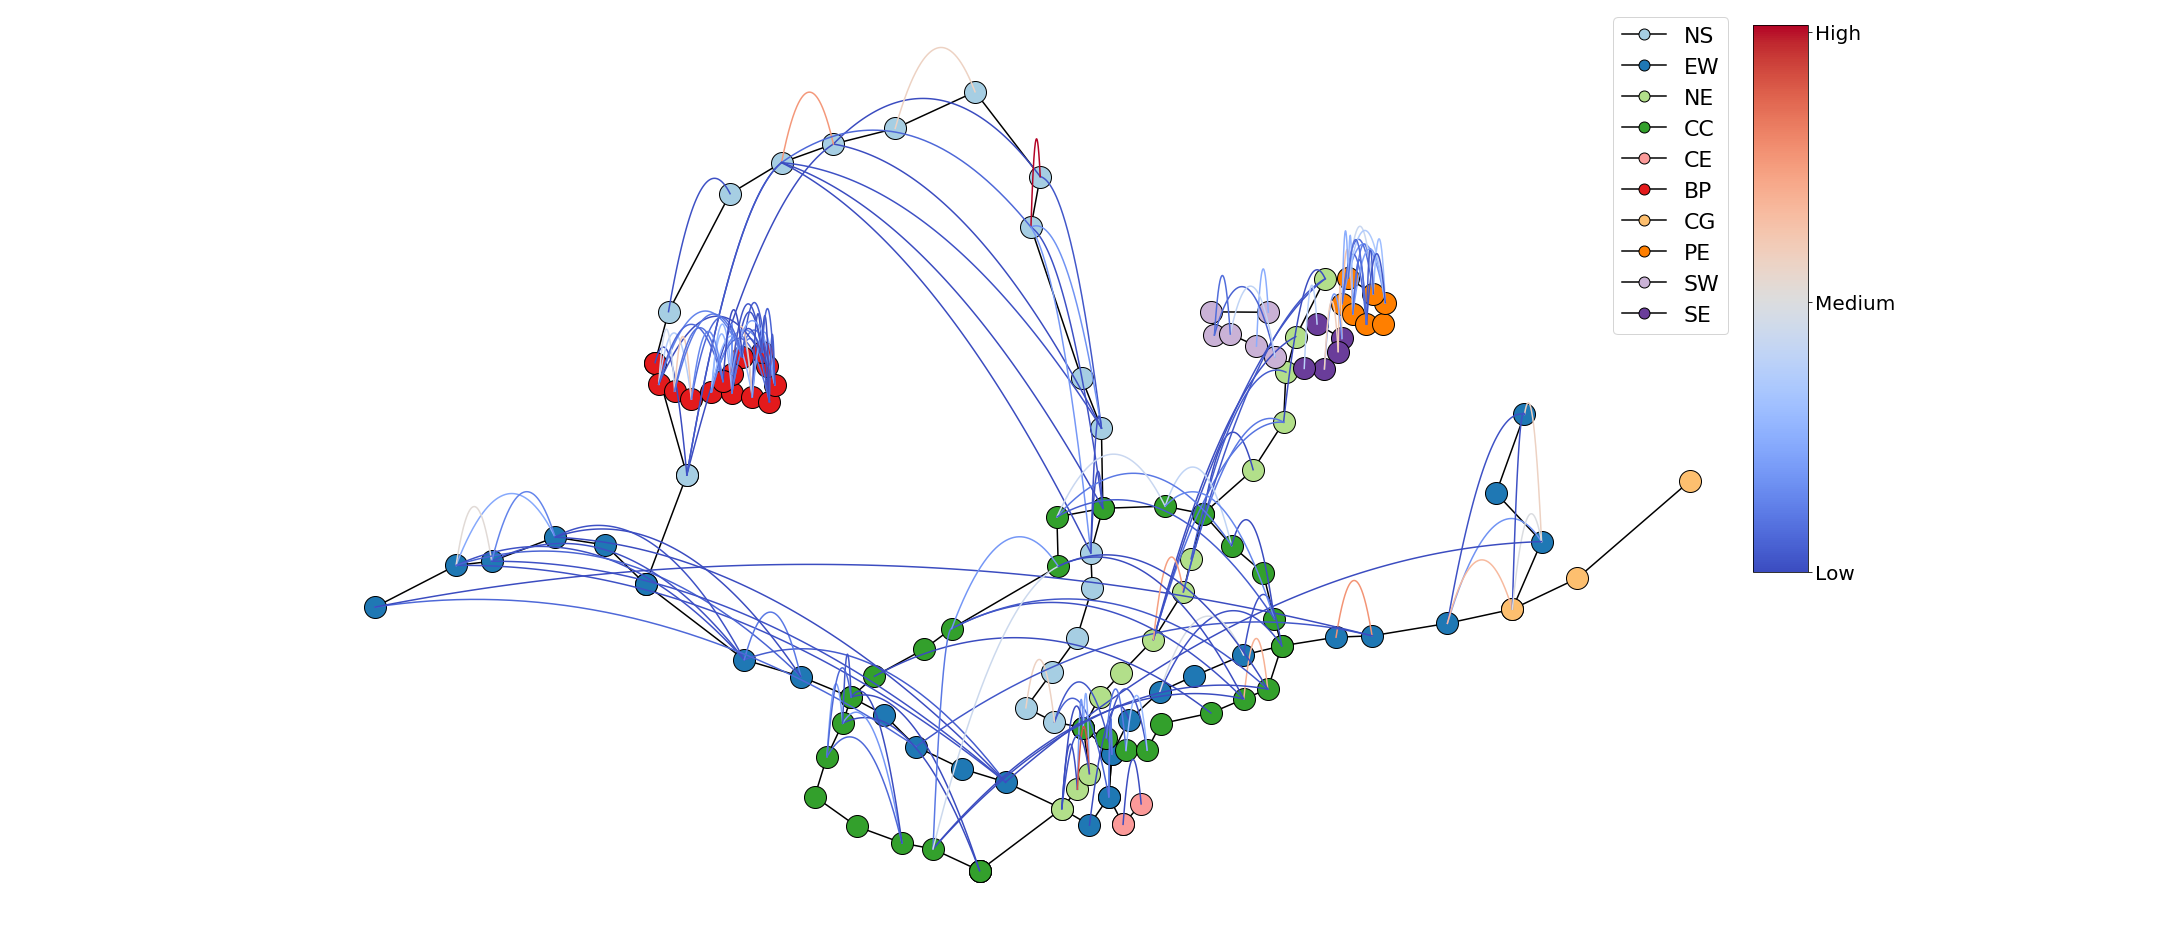

In [96]:
# Same line, same POI, same flow
plt.rcParams['figure.figsize'] = (38, 19)
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(103.6,104.1)
ax.set_axis_off()

#map_sg.plot(ax=ax,color=plt.cm.binary(100))

lgd=[]
cnt=0
for line in MRTLineNames:
    stn_lines=line_stn_dict[line][0]
    stn_line_num=[int(e[2:]) for e in stn_lines ]
    ix=np.argsort(stn_line_num)
    idx=np.array(line_stn_dict[line][1])[ix] #index for MRTStops
    lt=MRTStops['MRTLat'][idx]
    lg=MRTStops['MRTLng'][idx]
    
    ax.plot(lg,lt,marker='o',markerfacecolor=plt.cm.Paired(cnt),color='black',markersize=22)
    #ax.plot(lg,lt,marker='o')
    lgd.append(line)
    cnt+=1

ax.legend(lgd,loc='best',bbox_to_anchor=(0.8,1),markerscale=0.5,fontsize=22)

w_min=np.min([len(e[5]) for e in stns_sP_sF])
w_max=np.max([len(e[5]) for e in stns_sP_sF])
_w=[]
sc=255/(w_max-w_min)
for i in range(len(stns_sP_sF)):
    ix1=stns_sP_sF[i][0]
    ix2=stns_sP_sF[i][1]
    w=len(stns_sP_sF[i][5])
    t1,t2=getSplinePoints([MRTStops['MRTLng'][ix1],MRTStops['MRTLat'][ix1]],[MRTStops['MRTLng'][ix2],MRTStops['MRTLat'][ix2]],w)
    ax.plot(t1,t2,color=plt.cm.coolwarm(int((w-w_min)*sc)))
    _w.append(w)


cb_ax = fig.add_axes([0.75, 0.42 , 0.02, 0.4])
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm,norm=plt.Normalize(vmin=w_min,vmax=w_max))
sm._A=_w
cbar=fig.colorbar(sm,ax=ax,cax=cb_ax)
cbar.set_ticks(np.arange(w_min, w_max+1, int((w_max-w_min)/2)))
cbar.ax.set_yticklabels(['Low','Medium','High'],fontsize=20)

#plt.tight_layout()
#ax.set_title('Flow similarity for stations in the same line with same POI category')
plt.savefig('stns_sP_sF_20190421.pdf')
plt.savefig('stns_sP_sF_20190421.png')
plt.show()

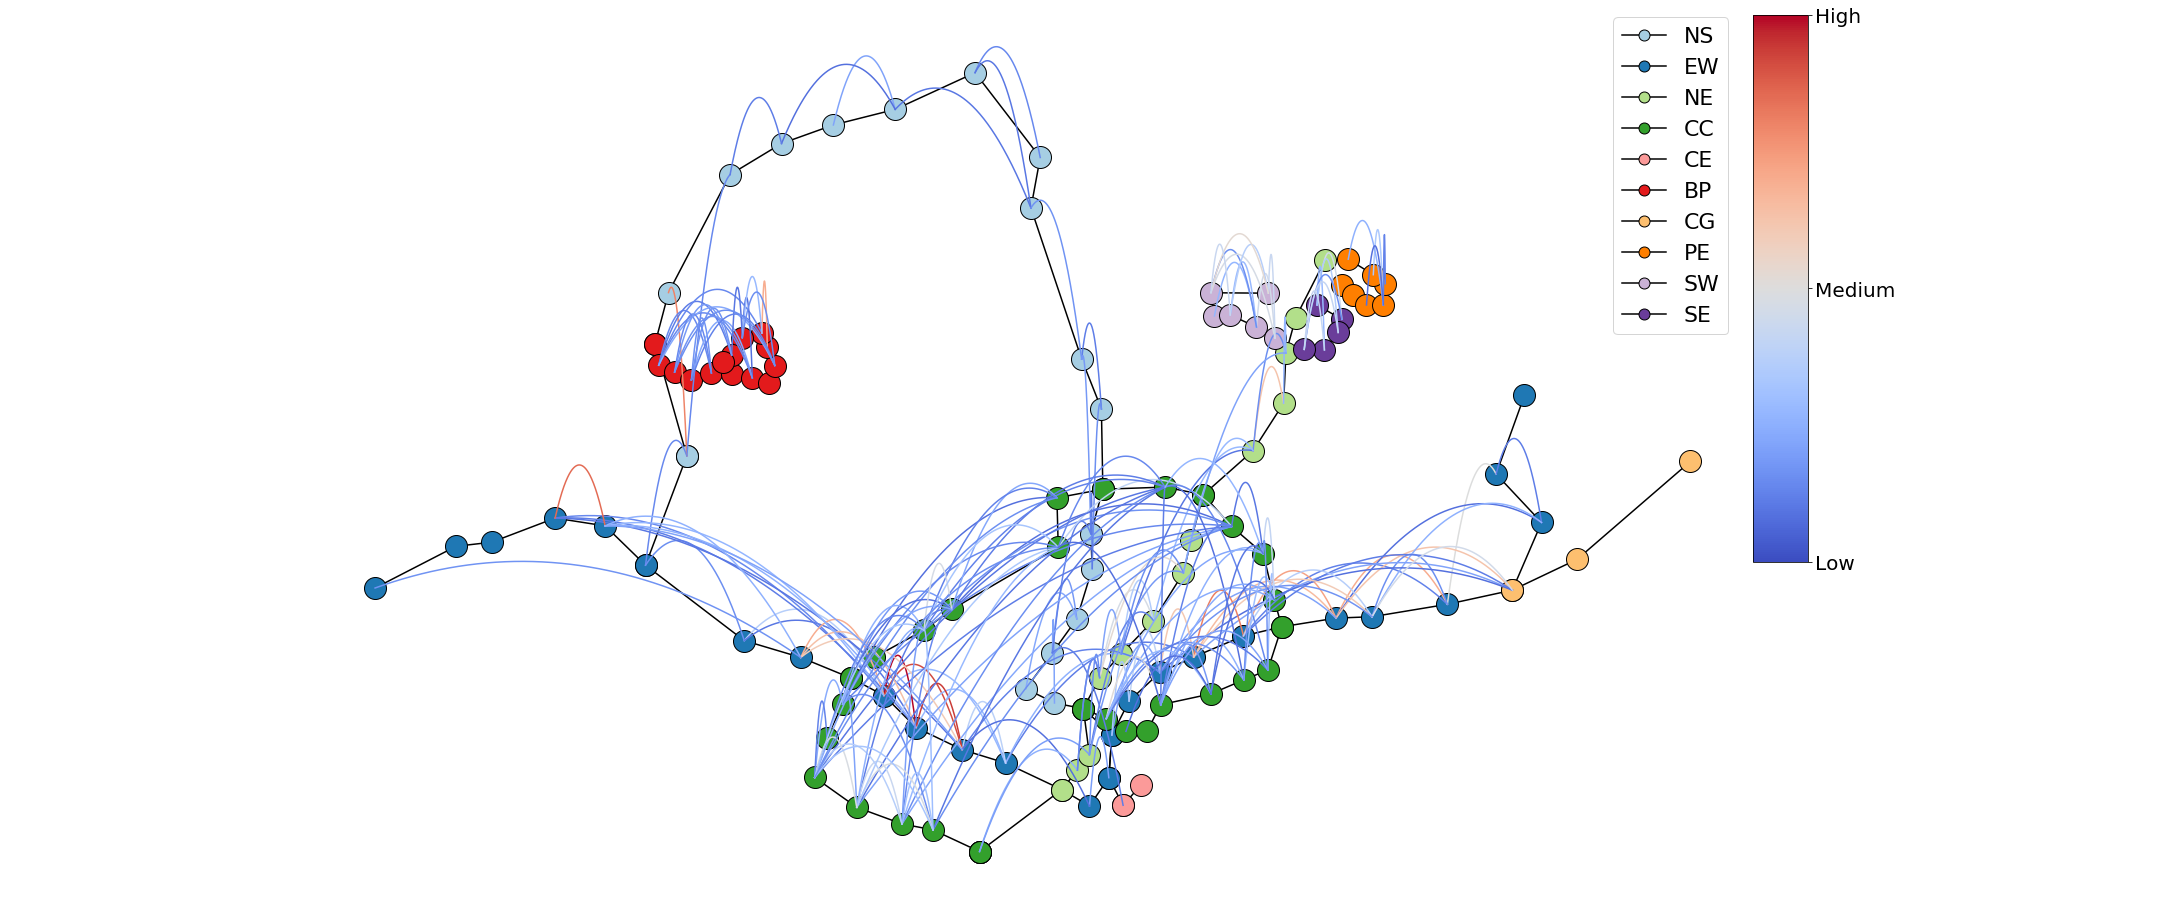

In [98]:
# Same line, same POI, same flow
plt.rcParams['figure.figsize'] = (38, 19)
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(103.6,104.1)
ax.set_axis_off()

#map_sg.plot(ax=ax,color=plt.cm.binary(100))

lgd=[]
cnt=0
for line in MRTLineNames:
    stn_lines=line_stn_dict[line][0]
    stn_line_num=[int(e[2:]) for e in stn_lines ]
    ix=np.argsort(stn_line_num)
    idx=np.array(line_stn_dict[line][1])[ix] #index for MRTStops
    lt=MRTStops['MRTLat'][idx]
    lg=MRTStops['MRTLng'][idx]
    
    ax.plot(lg,lt,marker='o',markerfacecolor=plt.cm.Paired(cnt),color='black',markersize=22)
    #ax.plot(lg,lt,marker='o')
    lgd.append(line)
    cnt+=1

ax.legend(lgd,loc='best',bbox_to_anchor=(0.8,1),markerscale=0.5,fontsize=22)

w_min=np.min([len(e[5]) for e in stns_dP_sF])
w_max=np.max([len(e[5]) for e in stns_dP_sF])
_w=[]
sc=255/(w_max-w_min)
for i in range(len(stns_dP_sF)):
    ix1=stns_dP_sF[i][0]
    ix2=stns_dP_sF[i][1]
    w=len(stns_dP_sF[i][5])
    if w>=7:
        t1,t2=getSplinePoints([MRTStops['MRTLng'][ix1],MRTStops['MRTLat'][ix1]],[MRTStops['MRTLng'][ix2],MRTStops['MRTLat'][ix2]],w)
        ax.plot(t1,t2,color=plt.cm.coolwarm(int((w-w_min)*sc)))
        _w.append(w)


cb_ax = fig.add_axes([0.75, 0.42 , 0.02, 0.4])
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm,norm=plt.Normalize(vmin=w_min,vmax=w_max))
sm._A=_w
cbar=fig.colorbar(sm,ax=ax,cax=cb_ax)
cbar.set_ticks(np.arange(w_min, w_max+1, int((w_max-w_min)/2)))
cbar.ax.set_yticklabels(['Low','Medium','High'],fontsize=20)

#plt.tight_layout()
#ax.set_title('Flow similarity for stations in the same line with same POI category')
plt.savefig('stns_dP_sF_20190421.pdf')
plt.savefig('stns_dP_sF_20190421.png')
plt.show()

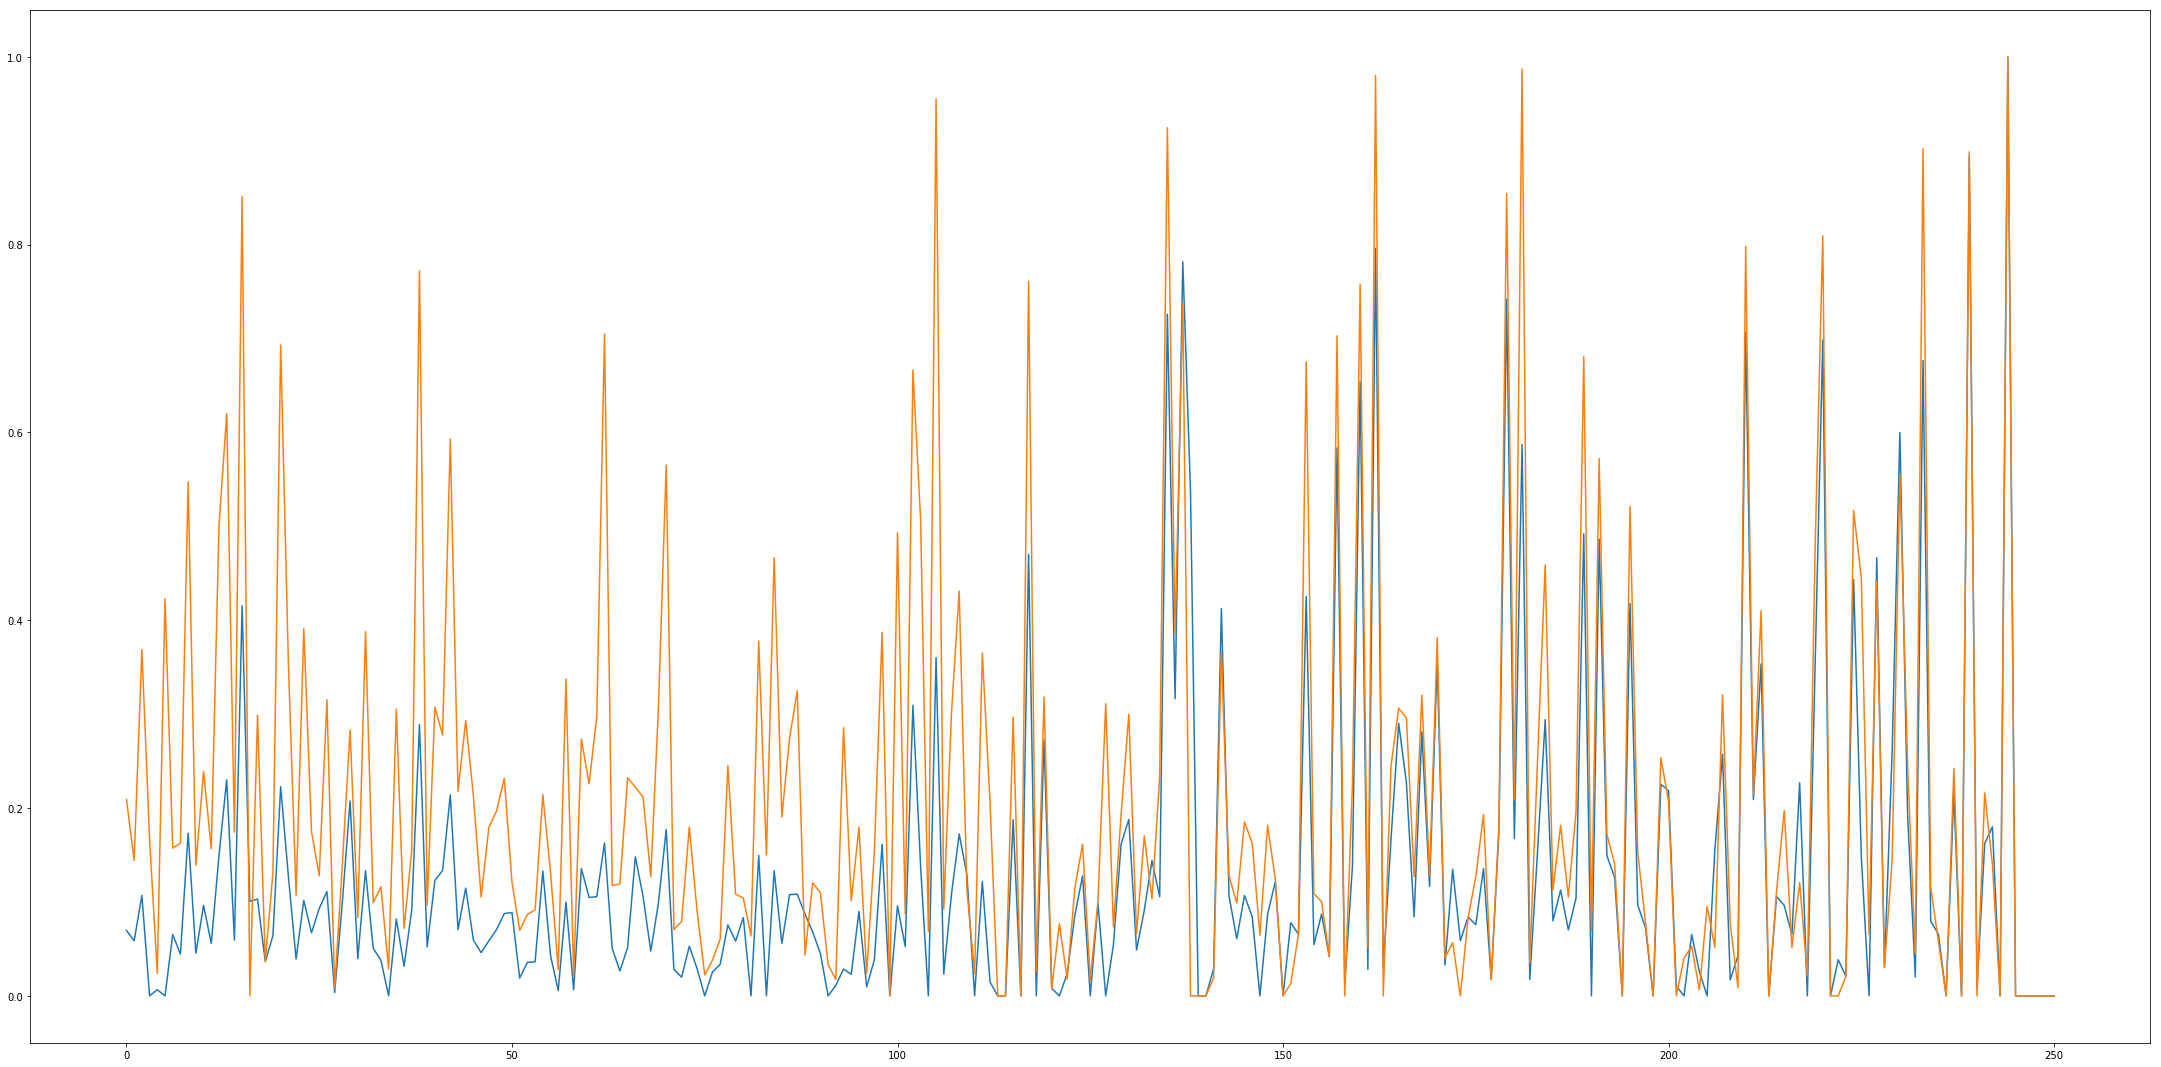

In [99]:
line_stn_dict['EW']
stationDict[5]
plt.plot(train_data_tint_1[5])
plt.plot(train_data_tint_1[16])

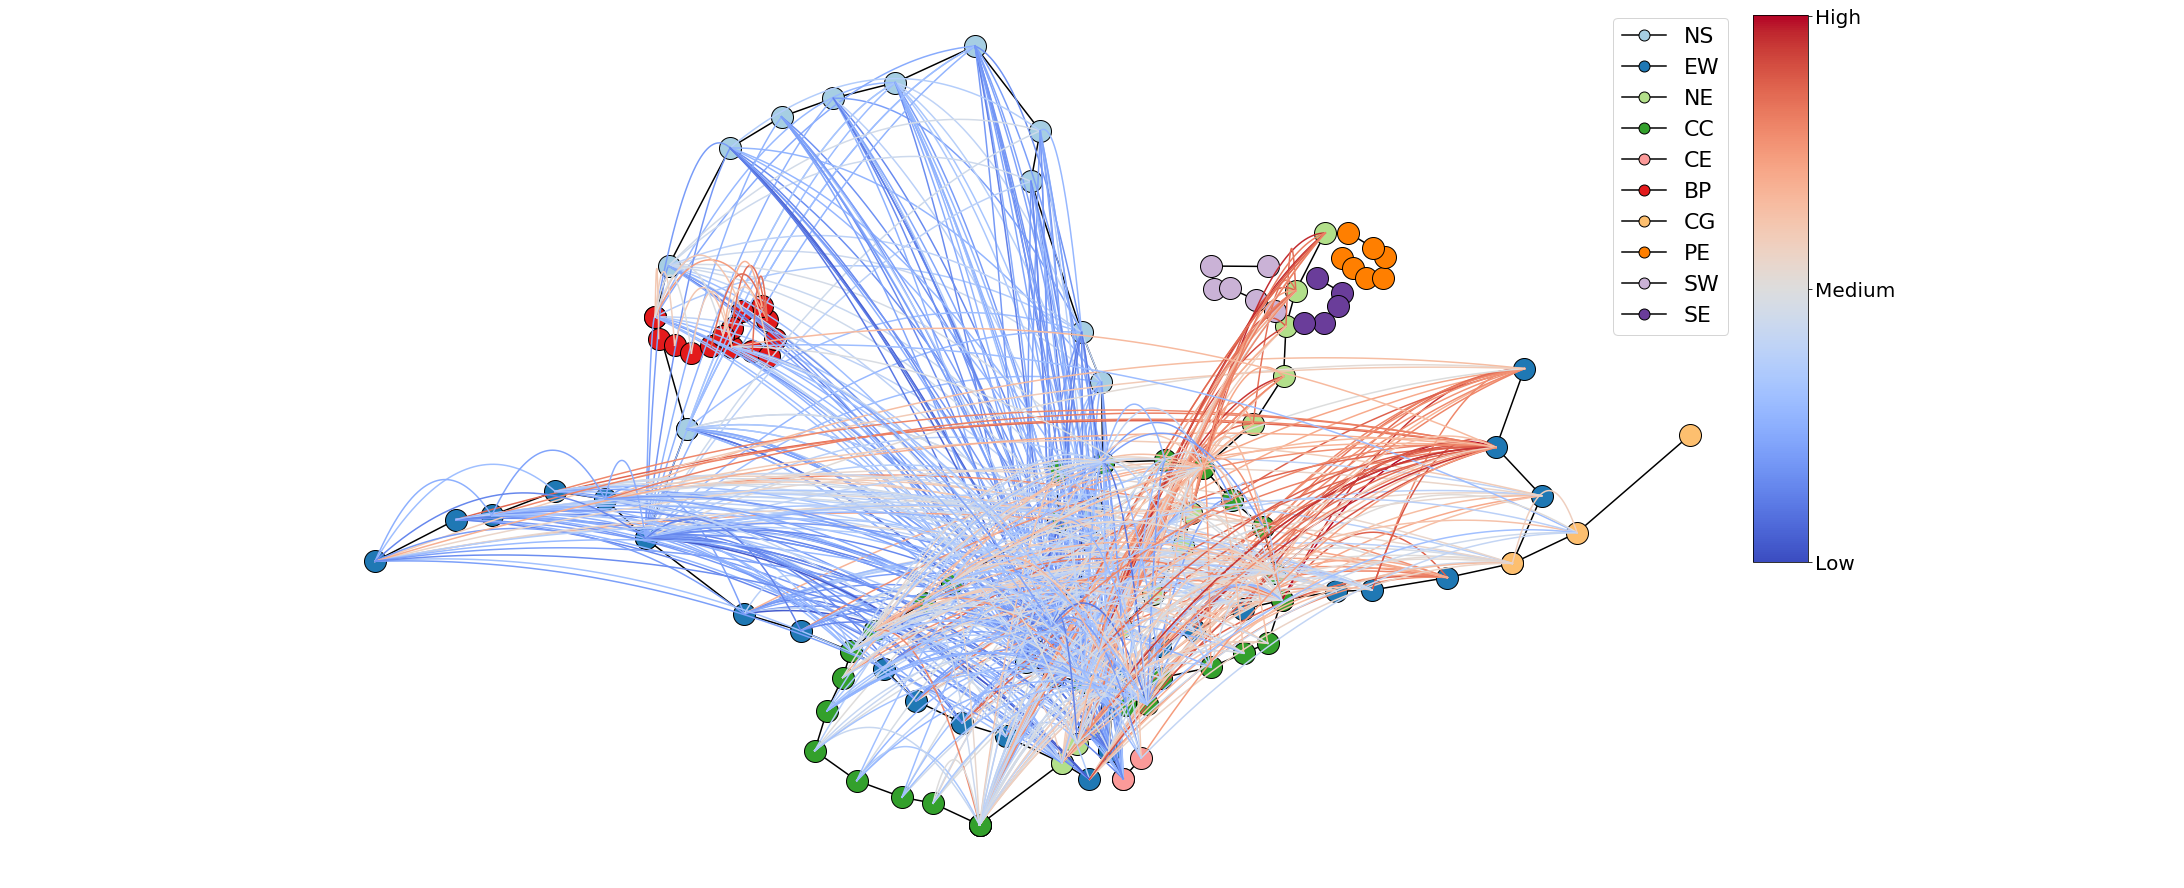

In [101]:
# Same line, same POI, same flow
plt.rcParams['figure.figsize'] = (38, 19)
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(103.6,104.1)
ax.set_axis_off()

#map_sg.plot(ax=ax,color=plt.cm.binary(100))

lgd=[]
cnt=0
for line in MRTLineNames:
    stn_lines=line_stn_dict[line][0]
    stn_line_num=[int(e[2:]) for e in stn_lines ]
    ix=np.argsort(stn_line_num)
    idx=np.array(line_stn_dict[line][1])[ix] #index for MRTStops
    lt=MRTStops['MRTLat'][idx]
    lg=MRTStops['MRTLng'][idx]
    
    ax.plot(lg,lt,marker='o',markerfacecolor=plt.cm.Paired(cnt),color='black',markersize=22)
    #ax.plot(lg,lt,marker='o')
    lgd.append(line)
    cnt+=1

ax.legend(lgd,loc='best',bbox_to_anchor=(0.8,1),markerscale=0.5,fontsize=22)

w_min=np.min([len(e[5]) for e in stns_dP_dF])
w_max=np.max([len(e[5]) for e in stns_dP_dF])
_w=[]
sc=255/(w_max-w_min)
for i in range(len(stns_dP_dF)):
    ix1=stns_dP_dF[i][0]
    ix2=stns_dP_dF[i][1]
    w=len(stns_dP_dF[i][5])
    if w>=7:
        t1,t2=getSplinePoints([MRTStops['MRTLng'][ix1],MRTStops['MRTLat'][ix1]],[MRTStops['MRTLng'][ix2],MRTStops['MRTLat'][ix2]],w)
        ax.plot(t1,t2,color=plt.cm.coolwarm(int((w-w_min)*sc)))
        _w.append(w)


cb_ax = fig.add_axes([0.75, 0.41 , 0.02, 0.4])
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm,norm=plt.Normalize(vmin=w_min,vmax=w_max))
sm._A=_w
cbar=fig.colorbar(sm,ax=ax,cax=cb_ax)
cbar.set_ticks(np.arange(w_min, w_max+1, int((w_max-w_min)/2)))
cbar.ax.set_yticklabels(['Low','Medium','High'],fontsize=20)

#plt.tight_layout()
#ax.set_title('Flow similarity for stations in the same line with same POI category')
plt.savefig('stns_dP_dF_20190421.pdf')
plt.savefig('stns_dP_dF_20190421.png')
plt.show()

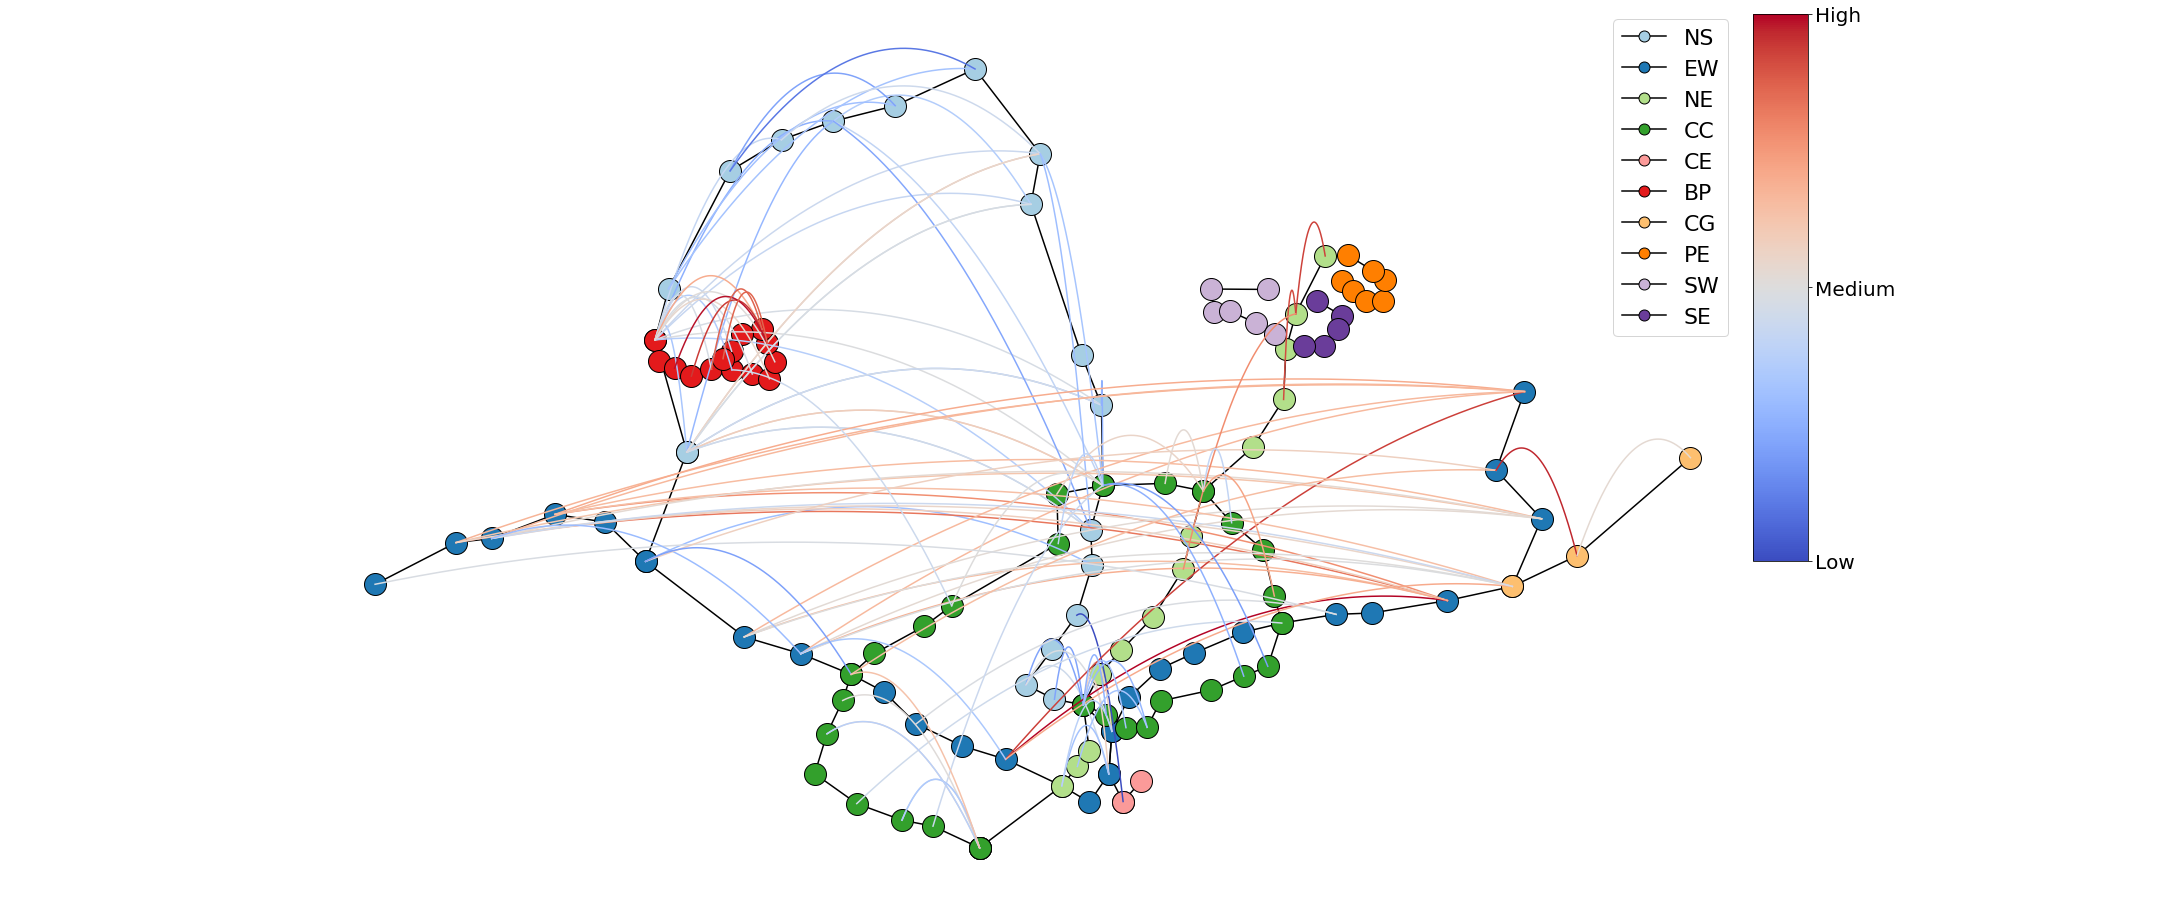

In [102]:
# Same line, same POI, same flow
plt.rcParams['figure.figsize'] = (38, 19)
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(103.6,104.1)
ax.set_axis_off()

#map_sg.plot(ax=ax,color=plt.cm.binary(100))

lgd=[]
cnt=0
for line in MRTLineNames:
    stn_lines=line_stn_dict[line][0]
    stn_line_num=[int(e[2:]) for e in stn_lines ]
    ix=np.argsort(stn_line_num)
    idx=np.array(line_stn_dict[line][1])[ix] #index for MRTStops
    lt=MRTStops['MRTLat'][idx]
    lg=MRTStops['MRTLng'][idx]
    
    ax.plot(lg,lt,marker='o',markerfacecolor=plt.cm.Paired(cnt),color='black',markersize=22)
    #ax.plot(lg,lt,marker='o')
    lgd.append(line)
    cnt+=1

ax.legend(lgd,loc='best',bbox_to_anchor=(0.8,1),markerscale=0.5,fontsize=22)

w_min=np.min([len(e[5]) for e in stns_sP_dF])
w_max=np.max([len(e[5]) for e in stns_sP_dF])
_w=[]
sc=255/(w_max-w_min)
for i in range(len(stns_sP_dF)):
    ix1=stns_sP_dF[i][0]
    ix2=stns_sP_dF[i][1]
    w=len(stns_sP_dF[i][5])
    t1,t2=getSplinePoints([MRTStops['MRTLng'][ix1],MRTStops['MRTLat'][ix1]],[MRTStops['MRTLng'][ix2],MRTStops['MRTLat'][ix2]],w)
    ax.plot(t1,t2,color=plt.cm.coolwarm(int((w-w_min)*sc)))
    _w.append(w)


cb_ax = fig.add_axes([0.75, 0.42 , 0.02, 0.4])
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm,norm=plt.Normalize(vmin=w_min,vmax=w_max))
sm._A=_w
cbar=fig.colorbar(sm,ax=ax,cax=cb_ax)
cbar.set_ticks(np.arange(w_min, w_max+1, int((w_max-w_min)/2)))
cbar.ax.set_yticklabels(['Low','Medium','High'],fontsize=20)

#plt.tight_layout()
#ax.set_title('Flow similarity for stations in the same line with same POI category')
plt.savefig('stns_sP_dF_20190421.pdf')
plt.savefig('stns_sP_dF_20190421.png')
plt.show()

# Analyze trained result and try to interprete

Train loss results

In [105]:
for i in range(7):
    eq0='his_{:}=joblib.load("../model_0801/history_withoutstn_tint_{:}_loss.asv")'.format(i,i)
    exec(eq0)

140
0.0014948329
140
0.001002024
140
0.00073904765
140
0.0013751504
140
0.0009142271
70
0.001276965
140
0.0014472523


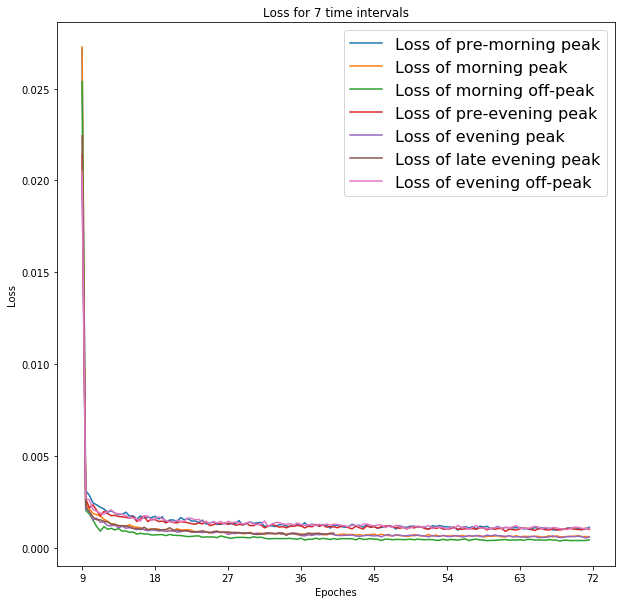

In [106]:
plt.rcParams['figure.figsize']=(10,10)
fig,ax=plt.subplots()
lgd=[]
for i in range(7):
    eq0='loss_idx=np.arange(0,len(his_{:}["batch"])-1,10000)'.format(i)
    eq1='loss_toplot=[his_{:}["batch"][int(e)] for e in list(loss_idx)]'.format(i)
    exec(eq0)
    exec(eq1)
    print(len(loss_idx))
    print(np.mean(loss_toplot))
    ax.plot(loss_toplot)
    lgd.append('Loss of {:}'.format(tint_dict[i]))
ax.legend(lgd)
ax.set_title('Loss for 7 time intervals')
ax.set_xticklabels(np.arange(0,140*10000,9))
plt.xlabel('Epoches')

plt.ylabel('Loss')
plt.savefig('loss_7tints_10_10.png')

In [107]:
t1=[]
t2=[]
t3=[]
t4=[]
t5=[]
t6=[]
for i in range(7):
    eq0='pred_tint_{:}=autoencoder_tint_{:}.predict(train_data_tint_{:})'.format(i,i,i)
    eq2='b=scaler_tint_{:}.inverse_transform(pred_tint_{:}-train_data_tint_{:})'.format(i,i,i)
    exec(eq0)
    exec(eq2)
    t1.append(np.mean(np.abs(b)))
    t2.append(np.mean(np.abs(b)/np.std(flowDict_tint[i])))
    t3.append(np.sum((np.abs(b)//np.std(flowDict_tint[i]))>0.05))
    t4.append(np.sum((np.abs(b)//np.std(flowDict_tint[i]))>0.05)/(854*251))
    t5.append(np.sum(np.abs(b)>10))
    t6.append(np.sum(np.abs(b)>10)/(854*251))
    print('For Average real deviation of tint ' ,i, 'in 7 days: ',
          np.mean(np.abs(b)))
    print('Average real deviation/std of tint ' ,i, 'in  7 days: ',
          np.mean(np.abs(b)/np.std(flowDict_tint[i])))
    print('Outliers (deviation/std>0.05) of tint ' ,i, ' in 854*251 elements: ',
          np.sum((np.abs(b)//np.std(flowDict_tint[i]))>0.05),
          'Portion: ',np.sum((np.abs(b)//np.std(flowDict_tint[i]))>0.05)/(854*251))
    print('Outliers (real deviation>10) tint ' ,i, ' in 854*251 elements:',
          np.sum(np.abs(b)>10),'Portion: ',
          np.sum(np.abs(b)>10)/(854*251))
    print('\n')

print('Average real deviation in 7 days: ',
      np.mean(t1))
print('Average real deviation/std in 7 days: ',
      np.mean(t2))
print('Average outliers (deviation/std>0.05) of 854*251 elements in 7 days: ',
      np.mean(t3),
      'Portion: ',np.mean(t4))
print('Average outliers (real deviation>10) of 854*251 elements in 7 days:',
      np.mean(t5),'Portion: ',
      np.mean(t6))

For Average real deviation of tint  0 in 7 days:  1.3743401692814625
Average real deviation/std of tint  0 in  7 days:  0.07140313813382253
Outliers (deviation/std>0.05) of tint  0  in 854*251 elements:  478 Portion:  0.002229956054004124
Outliers (real deviation>10) tint  0  in 854*251 elements: 2847 Portion:  0.0132817675434095


For Average real deviation of tint  1 in 7 days:  4.644504619745377
Average real deviation/std of tint  1 in  7 days:  0.05132609812424376
Outliers (deviation/std>0.05) of tint  1  in 854*251 elements:  128 Portion:  0.0005971430437500583
Outliers (real deviation>10) tint  1  in 854*251 elements: 27009 Portion:  0.1260018474112916


For Average real deviation of tint  2 in 7 days:  6.463259723738973
Average real deviation/std of tint  2 in  7 days:  0.06566491572522357
Outliers (deviation/std>0.05) of tint  2  in 854*251 elements:  392 Portion:  0.0018287505714845536
Outliers (real deviation>10) tint  2  in 854*251 elements: 39016 Portion:  0.182016664023064